## This notebook presents the reproducible procedure that we followed in comparing the performance of Hybrid Quantum-Classical Neural Networks and Classical Convolutional Neural Networks on the GlaucomaFundus dataset. The GlaucomaFundus dataset is a glaucoma-focused dataset with 1544 fundus images. The dataset was produced in South Korea and is labeled with three-category classification (Non-Glaucoma, Early Glaucoma, and Glaucoma).

### Installing and Importing Dependencies

In [ ]:
!pip install pennylane

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 68.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 56.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 48.4 MB/s eta 0:00:00


In [ ]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import os
from google.colab import drive
import cv2
from sklearn.model_selection import train_test_split
import pandas as pd
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, Sampler
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, transforms
from PIL import Image
import time
import os
import copy
from torch.optim.lr_scheduler import CosineAnnealingLR
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, confusion_matrix, roc_curve,
    precision_recall_curve, auc
)
from sklearn.preprocessing import label_binarize
import random


os.environ["OMP_NUM_THREADS"] = "1"

In [ ]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
MODEL_SAVE_PATH = "/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/GlaucomaFundus_models/"

### Classical CNN Model Construction and General Methods

In [ ]:
class NormalModel(nn.Module):
  def __init__(self, freeze, num_classes, device='cuda'):
        super(NormalModel, self).__init__()

        weights = torchvision.models.ResNet18_Weights.IMAGENET1K_V1
        self.model = torchvision.models.resnet18(weights=weights)

        if freeze:
          for param in self.model.parameters():
              param.requires_grad = False

        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)
        self.model = self.model.to(device)

  def forward(self, x):
        return self.model(x)

In [ ]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True

In [ ]:
class TwoClassImageFolder(datasets.ImageFolder):
    def __init__(self, root, transform=None):
        super().__init__(root, transform)

        self.class_to_idx = {
            'anormal': 0,
            'bsuspectglaucoma': 1,
            'cglaucoma': 1
        }

    def __getitem__(self, index):
        # Get original image and label
        path, original_target = self.samples[index]
        sample = self.loader(path)

        if self.transform is not None:
            sample = self.transform(sample)

        target_class_name = self.classes[original_target]
        target = self.class_to_idx[target_class_name]

        return sample, target

In [ ]:
def load_data(batch_size, dataset, PAPILA_dual_class=False):

  train_transform = transforms.Compose([
      transforms.Resize((224, 224)),
      transforms.RandomHorizontalFlip(),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
  ])

  valid_test_transform = transforms.Compose([
      transforms.Resize((224, 224)),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
  ])


  if dataset == 'APTOS':
    data_dir = "/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/APTOS2019/"

  elif dataset == "IDRID":
    data_dir = "/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/IDRID_images/"

  elif dataset == "Messidor":
    data_dir = "/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/MESSIDOR2/"

  elif dataset == "GlaucomaFundus":
    data_dir = "/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/Glaucoma_fundus/"

  elif dataset == "PAPILA":
    data_dir = "/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/PAPILA/"

    if PAPILA_dual_class:
      train_dataset = TwoClassImageFolder(root=os.path.join(data_dir, 'train'), transform=train_transform)
      val_dataset = TwoClassImageFolder(root=os.path.join(data_dir, 'val'), transform=valid_test_transform)
      test_dataset = TwoClassImageFolder(root=os.path.join(data_dir, 'test'), transform=valid_test_transform)

    else:
      train_dataset = datasets.ImageFolder(root=data_dir + 'train', transform=train_transform)
      val_dataset = datasets.ImageFolder(root=data_dir + 'val', transform=valid_test_transform)
      test_dataset = datasets.ImageFolder(root=data_dir + 'test', transform=valid_test_transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

    return train_loader, val_loader, test_loader


  elif dataset == 'G1020':
    data_dir = "/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/G1020/"


  train_dataset = datasets.ImageFolder(root=data_dir + 'train', transform=train_transform)
  val_dataset = datasets.ImageFolder(root=data_dir + 'val', transform=valid_test_transform)
  test_dataset = datasets.ImageFolder(root=data_dir + 'test', transform=valid_test_transform)

  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
  valid_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
  test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

  return train_loader, valid_loader, test_loader

### Hybrid Quantum-classical Neural Network Construction

In [ ]:
n_qubits = 4                # Number of qubits
step = 0.0004               # Learning rate
batch_size = 4              # Number of samples for each training step
q_delta = 0.01              # Initial spread of random quantum weights
start_time = time.time()    # Start of the computation timer

In [ ]:
def H_layer(nqubits):
    """Layer of single-qubit Hadamard gates.
    """
    for idx in range(nqubits):
        qml.Hadamard(wires=idx)


def RY_layer(w):
    """Layer of parametrized qubit rotations around the y axis.
    """
    for idx, element in enumerate(w):
        qml.RY(element, wires=idx)


def entangling_layer(nqubits):
    """Layer of CNOTs followed by another shifted layer of CNOT.
    """
    for i in range(0, nqubits - 1, 2):
        qml.CNOT(wires=[i, i + 1])
    for i in range(1, nqubits - 1, 2):
        qml.CNOT(wires=[i, i + 1])

In [ ]:
dev = qml.device("default.qubit", wires=n_qubits)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
@qml.qnode(dev)
def quantum_net(q_input_features, q_weights_flat):
    """
    The variational quantum circuit.
    """

    # Reshape weights
    q_weights = q_weights_flat.reshape(q_depth, n_qubits)

    # Start from state |+> , unbiased w.r.t. |0> and |1>
    H_layer(n_qubits)

    # Embed features in the quantum node
    RY_layer(q_input_features)

    # Sequence of trainable variational layers
    for k in range(q_depth):
        entangling_layer(n_qubits)
        RY_layer(q_weights[k])

    # Expectation values in the Z basis
    exp_vals = [qml.expval(qml.PauliZ(position)) for position in range(n_qubits)]
    return tuple(exp_vals)

In [ ]:
class DressedQuantumNet(nn.Module):

    def __init__(self, q_depth, num_classes):

        super().__init__()
        self.pre_net = nn.Linear(512, n_qubits)
        self.q_params = nn.Parameter(q_delta * torch.randn(q_depth * n_qubits))
        self.post_net = nn.Linear(n_qubits, num_classes)

    def forward(self, input_features):


        pre_out = self.pre_net(input_features)
        q_in = torch.tanh(pre_out) * np.pi / 2.0

        # Apply the quantum circuit to each element of the batch and append to q_out
        q_out = torch.Tensor(0, n_qubits)
        q_out = q_out.to(device)
        for elem in q_in:
            q_out_elem = torch.hstack(quantum_net(elem, self.q_params)).float().unsqueeze(0)
            q_out = torch.cat((q_out, q_out_elem))

        # return the two-dimensional prediction from the postprocessing layer
        return self.post_net(q_out)

In [ ]:
class QuantumHybridModel(nn.Module):
  def __init__(self, q_depth, freeze, num_classes, device='cuda'):
        super(QuantumHybridModel, self).__init__()

        weights = torchvision.models.ResNet18_Weights.IMAGENET1K_V1
        self.model = torchvision.models.resnet18(weights=weights)

        if freeze:
          for param in self.model.parameters():
              param.requires_grad = False

        self.model.fc = DressedQuantumNet(q_depth, num_classes)

        self.model = self.model.to(device)

  def forward(self, x):
        return self.model(x)

### General Training, Validation, Testing Functions

In [ ]:
import torchvision
from torchvision import datasets, transforms

In [ ]:
def train_model(model, train_loader, optimizer, criterion):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_probs = []

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        probs = torch.softmax(outputs, dim=1)
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.detach().cpu().numpy())



    avg_train_loss = train_loss / len(train_loader.dataset)
    accuracy = correct / total * 100

    aurocs = []
    for i in range(probs.shape[1]):
        try:
            auroc = roc_auc_score([1 if label == i else 0 for label in all_labels], [prob[i] for prob in all_probs])
            aurocs.append(auroc)
        except ValueError:
            aurocs.append(0)

    avg_auroc = sum(aurocs) / len(aurocs)

    return avg_train_loss, accuracy, avg_auroc

In [ ]:
def validate_model(model, valid_loader, criterion):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    all_labels = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            probs = torch.softmax(outputs, dim=1)
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.detach().cpu().numpy())

    avg_val_loss = val_loss / len(valid_loader.dataset)
    accuracy = correct / total * 100
    aurocs = []
    for i in range(probs.shape[1]):
        try:
            auroc = roc_auc_score([1 if label == i else 0 for label in all_labels], [prob[i] for prob in all_probs])
            aurocs.append(auroc)
        except ValueError:
            aurocs.append(0)

    avg_auroc = sum(aurocs) / len(aurocs)

    return avg_val_loss, accuracy, avg_auroc

In [ ]:
def train_validate_model(n_epochs, model, model_name, train_loader, valid_loader, seed):

  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

  def adjust_learning_rate(optimizer, epoch, lr_warmup_epochs, lr_max):
        if epoch < lr_warmup_epochs:
            lr = lr_max * (epoch + 1) / lr_warmup_epochs
        else:
            lr = lr_max
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr

  scheduler = CosineAnnealingLR(optimizer, T_max=n_epochs - 10, eta_min=1e-6)

  best_val_auc = float('-inf')
  best_model_weights = model.state_dict()
  epochs_without_improvement = 0

  train_losses = []
  train_accuracies = []
  val_losses = []
  val_accuracies = []
  train_aucs = []
  val_aucs = []

  lr_max = 5e-4
  lr_warmup_epochs = 10

  for epoch in range(n_epochs):
      print(f'Epoch [{epoch+1}/{n_epochs}]')

      adjust_learning_rate(optimizer, epoch, lr_warmup_epochs, lr_max)

      train_loss, train_accuracy, train_auroc = train_model(model, train_loader, optimizer, criterion)
      val_loss, val_accuracy, val_auroc = validate_model(model, valid_loader, criterion)


      print(f'Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%, Training AUROC: {train_auroc:.4f}')
      print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%, Validation AUROC: {val_auroc:.4f}')
      train_losses.append(train_loss)
      train_accuracies.append(train_accuracy)
      train_aucs.append(train_auroc)
      val_losses.append(val_loss)
      val_accuracies.append(val_accuracy)
      val_aucs.append(val_auroc)

      if epoch >= lr_warmup_epochs:
            scheduler.step()

      if val_auroc > best_val_auc:
            best_val_auc = val_auroc
            best_model_weights = model.state_dict()

  model.load_state_dict(best_model_weights)
  torch.save(model, os.path.join(MODEL_SAVE_PATH, f'{model_name}_{seed}.pth'))
  return model, train_losses, train_accuracies, val_losses, val_accuracies, train_aucs, val_aucs

In [ ]:
def plot(quantum_loss, normal_loss, quantum_acc, normal_acc, quantum_auc, normal_auc):
  plt.style.use("seaborn")
  fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

  ax1.plot(quantum_loss, label="With quantum layer")
  ax1.plot(normal_loss, label="Without quantum layer")
  ax1.set_ylabel("Loss")
  ax1.set_ylim([0, 1])
  ax1.set_xlabel("Epoch")
  ax1.legend()

  ax2.plot(quantum_acc, label="With quantum layer")
  ax2.plot(normal_acc, label="Without quantum layer")
  ax2.set_ylabel("Accuracy")
  ax2.set_ylim([0, 100])
  ax2.set_xlabel("Epoch")
  ax2.legend()

  ax2.plot(quantum_auc, label="With quantum layer")
  ax2.plot(normal_auc, label="Without quantum layer")
  ax2.set_ylabel("ROCAUC")
  ax2.set_ylim([0, 1])
  ax2.set_xlabel("Epoch")
  ax2.legend()

  plt.tight_layout()
  plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, auc, accuracy_score, f1_score
import numpy as np
import matplotlib.pyplot as plt
import torch

def test(model_hybrid, model_normal, test_loader, num_classes):
    model_hybrid.eval()
    model_normal.eval()

    all_labels = []
    all_preds_hybrid = []
    all_preds_normal = []
    all_probs_hybrid = []
    all_probs_normal = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            # Hybrid model predictions
            outputs_hybrid = model_hybrid(images)
            _, preds_hybrid = torch.max(outputs_hybrid, 1)
            probs_hybrid = torch.softmax(outputs_hybrid, dim=1)  # Probability for each class

            # Normal model predictions
            outputs_normal = model_normal(images)
            _, preds_normal = torch.max(outputs_normal, 1)
            probs_normal = torch.softmax(outputs_normal, dim=1)  # Probability for each class

            all_labels.extend(labels.cpu().numpy())
            all_preds_hybrid.extend(preds_hybrid.cpu().numpy())
            all_preds_normal.extend(preds_normal.cpu().numpy())
            all_probs_hybrid.extend(probs_hybrid.cpu().numpy())
            all_probs_normal.extend(probs_normal.cpu().numpy())

    all_labels = np.array(all_labels)
    all_probs_hybrid = np.array(all_probs_hybrid)
    all_probs_normal = np.array(all_probs_normal)

    # Calculate accuracy
    accuracy_hybrid = accuracy_score(all_labels, all_preds_hybrid)
    accuracy_normal = accuracy_score(all_labels, all_preds_normal)

    # Calculate F1 Score
    f1_hybrid = f1_score(all_labels, all_preds_hybrid, average='weighted')
    f1_normal = f1_score(all_labels, all_preds_normal, average='weighted')

    print(f'Hybrid Model Accuracy: {accuracy_hybrid * 100:.2f}%')
    print(f'Normal Model Accuracy: {accuracy_normal * 100:.2f}%')
    print(f'Hybrid Model F1 Score: {f1_hybrid:.4f}')
    print(f'Normal Model F1 Score: {f1_normal:.4f}')

    if num_classes == 2:  # Binary Classification
        # Extract the probabilities of the positive class (class 1)
        all_probs_hybrid_class1 = all_probs_hybrid[:, 1]
        all_probs_normal_class1 = all_probs_normal[:, 1]

        # Calculate AUC
        auc_hybrid = roc_auc_score(all_labels, all_probs_hybrid_class1)
        auc_normal = roc_auc_score(all_labels, all_probs_normal_class1)

        print(f'Hybrid Model AUC: {auc_hybrid:.4f}')
        print(f'Normal Model AUC: {auc_normal:.4f}')

        # Plot ROC curves
        fpr_hybrid, tpr_hybrid, _ = roc_curve(all_labels, all_probs_hybrid_class1)
        fpr_normal, tpr_normal, _ = roc_curve(all_labels, all_probs_normal_class1)

        plt.figure(figsize=(10, 6))
        plt.plot(fpr_hybrid, tpr_hybrid, label=f'Hybrid Model AUC = {auc_hybrid:.4f}')
        plt.plot(fpr_normal, tpr_normal, label=f'Normal Model AUC = {auc_normal:.4f}')
        plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random chance
        plt.title('ROC Curve - Hybrid and Normal Models')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(loc='lower right')
        plt.show()

        # Calculate and print AUPR
        precision_hybrid, recall_hybrid, _ = precision_recall_curve(all_labels, all_probs_hybrid_class1)
        precision_normal, recall_normal, _ = precision_recall_curve(all_labels, all_probs_normal_class1)

        aupr_hybrid = auc(recall_hybrid, precision_hybrid)
        aupr_normal = auc(recall_normal, precision_normal)

        print(f'Hybrid Model AUPR: {aupr_hybrid:.4f}')
        print(f'Normal Model AUPR: {aupr_normal:.4f}')

        # Plot Precision-Recall curves
        plt.figure(figsize=(10, 6))
        plt.plot(recall_hybrid, precision_hybrid, label=f'Hybrid Model AUPR = {aupr_hybrid:.4f}')
        plt.plot(recall_normal, precision_normal, label=f'Normal Model AUPR = {aupr_normal:.4f}')
        plt.title('Precision-Recall Curve - Hybrid and Normal Models')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.legend(loc='lower left')
        plt.show()

    else:  # Multi-class Classification
        # For multi-class, handle per class ROC and PR curves
        for i in range(num_classes):
            # Calculate AUC for each class
            fpr_hybrid, tpr_hybrid, _ = roc_curve(all_labels == i, all_probs_hybrid[:, i])
            fpr_normal, tpr_normal, _ = roc_curve(all_labels == i, all_probs_normal[:, i])

            auc_hybrid = roc_auc_score(all_labels == i, all_probs_hybrid[:, i])
            auc_normal = roc_auc_score(all_labels == i, all_probs_normal[:, i])

            plt.figure(figsize=(10, 6))
            plt.plot(fpr_hybrid, tpr_hybrid, label=f'Class {i} Hybrid Model AUC = {auc_hybrid:.4f}')
            plt.plot(fpr_normal, tpr_normal, label=f'Class {i} Normal Model AUC = {auc_normal:.4f}')
            plt.plot([0, 1], [0, 1], 'k--')
            plt.title(f'ROC Curve - Class {i}')
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.legend(loc='lower right')
            plt.show()

            # Precision-Recall Curve
            precision_hybrid, recall_hybrid, _ = precision_recall_curve(all_labels == i, all_probs_hybrid[:, i])
            precision_normal, recall_normal, _ = precision_recall_curve(all_labels == i, all_probs_normal[:, i])

            aupr_hybrid = auc(recall_hybrid, precision_hybrid)
            aupr_normal = auc(recall_normal, precision_normal)

            plt.figure(figsize=(10, 6))
            plt.plot(recall_hybrid, precision_hybrid, label=f'Class {i} Hybrid Model AUPR = {aupr_hybrid:.4f}')
            plt.plot(recall_normal, precision_normal, label=f'Class {i} Normal Model AUPR = {aupr_normal:.4f}')
            plt.title(f'Precision-Recall Curve - Class {i}')
            plt.xlabel('Recall')
            plt.ylabel('Precision')
            plt.legend(loc='lower left')
            plt.show()


# Experiments: Training Model on GlaucomaFundus - Testing on GlaucomaFundus

In [ ]:
n_epochs = 100
num_classes = 3
q_depth = 4
batch_size = 32
dataset = "GlaucomaFundus"
model_name_hybrid = 'quantum_hybrid_model'
model_name_normal = 'normal_model'

Seed Experiment 1

In [ ]:
seed = 0
set_seed(seed)
train_loader, valid_loader, test_loader = load_data(batch_size=batch_size, dataset=dataset)
model = NormalModel(freeze=True, num_classes=num_classes)
hybrid_model = QuantumHybridModel(q_depth=4, freeze=True, num_classes=num_classes)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
model_normal, normal_train_losses, normal_train_accs, normal_val_losses, normal_val_accs, normal_train_aucs, normal_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=model,
    model_name=model_name_normal,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed
)

Epoch [1/100]
Training Loss: 0.9914, Training Accuracy: 49.88%, Training AUROC: 0.6380
Validation Loss: 0.8727, Validation Accuracy: 56.77%, Validation AUROC: 0.6609
Epoch [2/100]
Training Loss: 0.8934, Training Accuracy: 57.81%, Training AUROC: 0.7054
Validation Loss: 0.7653, Validation Accuracy: 65.62%, Validation AUROC: 0.7416
Epoch [3/100]
Training Loss: 0.8521, Training Accuracy: 59.98%, Training AUROC: 0.7452
Validation Loss: 0.7363, Validation Accuracy: 67.19%, Validation AUROC: 0.7886
Epoch [4/100]
Training Loss: 0.7907, Training Accuracy: 63.94%, Training AUROC: 0.8020
Validation Loss: 0.7002, Validation Accuracy: 66.15%, Validation AUROC: 0.8186
Epoch [5/100]
Training Loss: 0.7489, Training Accuracy: 65.62%, Training AUROC: 0.8241
Validation Loss: 0.6747, Validation Accuracy: 68.75%, Validation AUROC: 0.8360
Epoch [6/100]
Training Loss: 0.7104, Training Accuracy: 68.51%, Training AUROC: 0.8451
Validation Loss: 0.6202, Validation Accuracy: 69.27%, Validation AUROC: 0.8474
Epoc

In [ ]:
model_hybrid, hybrid_train_losses, hybrid_train_accs, hybrid_val_losses, hybrid_val_accs, hybrid_train_aucs, hybrid_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=hybrid_model,
    model_name=model_name_hybrid,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed
)

Epoch [1/100]
Training Loss: 1.0464, Training Accuracy: 43.27%, Training AUROC: 0.5672
Validation Loss: 0.9115, Validation Accuracy: 54.69%, Validation AUROC: 0.5302
Epoch [2/100]
Training Loss: 0.9957, Training Accuracy: 51.80%, Training AUROC: 0.6320
Validation Loss: 0.8614, Validation Accuracy: 57.81%, Validation AUROC: 0.6304
Epoch [3/100]
Training Loss: 0.9614, Training Accuracy: 51.32%, Training AUROC: 0.6633
Validation Loss: 0.8298, Validation Accuracy: 57.81%, Validation AUROC: 0.6573
Epoch [4/100]
Training Loss: 0.9302, Training Accuracy: 51.20%, Training AUROC: 0.6828
Validation Loss: 0.8189, Validation Accuracy: 58.33%, Validation AUROC: 0.6792
Epoch [5/100]
Training Loss: 0.8958, Training Accuracy: 53.85%, Training AUROC: 0.7198
Validation Loss: 0.7911, Validation Accuracy: 65.10%, Validation AUROC: 0.7082
Epoch [6/100]
Training Loss: 0.8630, Training Accuracy: 64.30%, Training AUROC: 0.7535
Validation Loss: 0.7563, Validation Accuracy: 67.19%, Validation AUROC: 0.7828
Epoc

<ipython-input-17-c59c089c574e>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


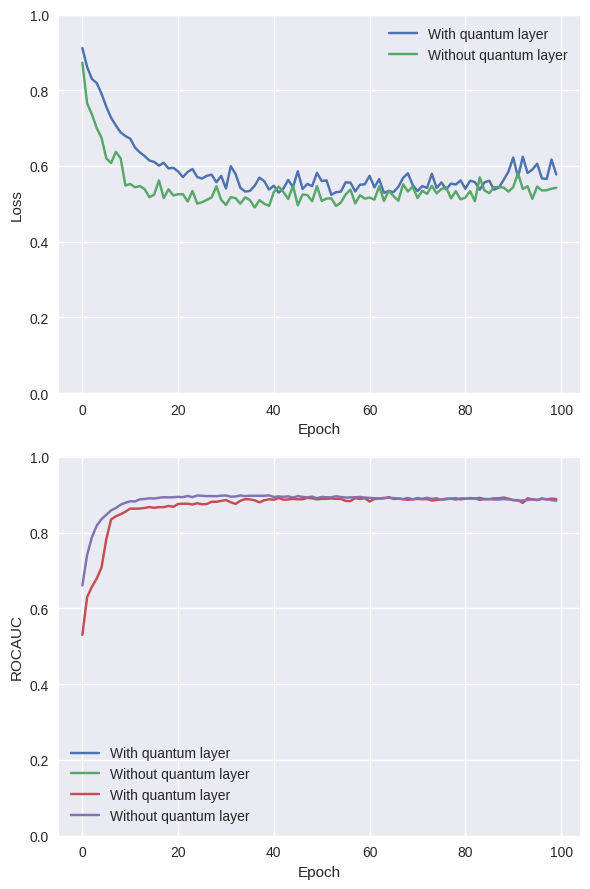

In [ ]:
plot(hybrid_val_losses, normal_val_losses, hybrid_val_accs, normal_val_accs, hybrid_val_aucs, normal_val_aucs)

Hybrid Model Accuracy: 74.11%
Normal Model Accuracy: 74.33%
Hybrid Model F1 Score: 0.7367
Normal Model F1 Score: 0.7182
Hybrid Model AUC: 0.8722
Normal Model AUC: 0.8736


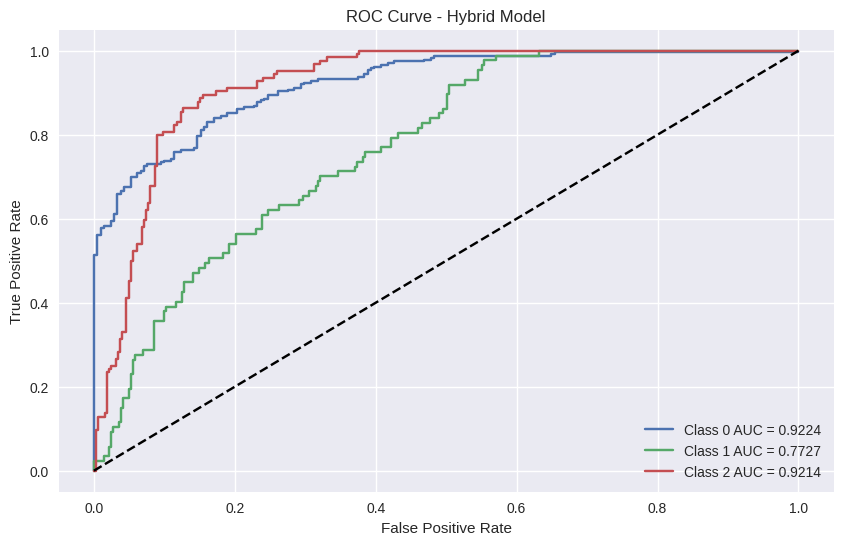

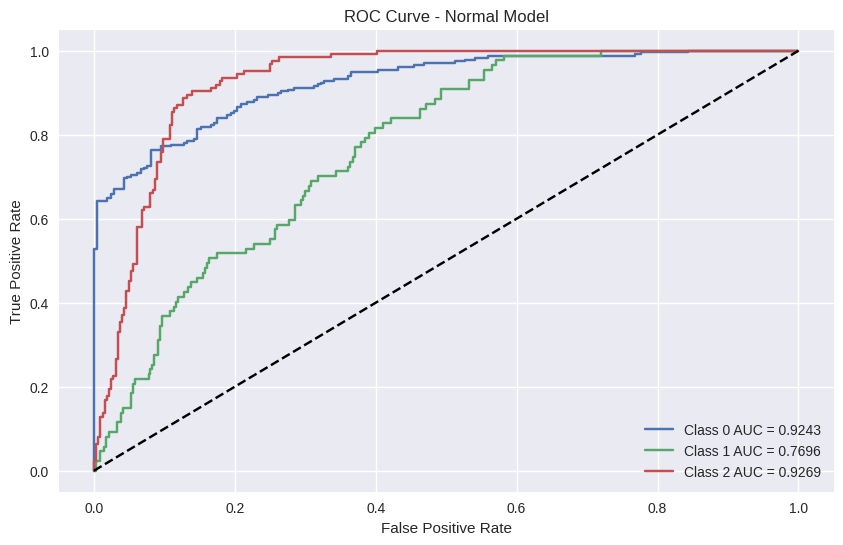

Hybrid Model AUPR: 0.6965
Normal Model AUPR: 0.6957


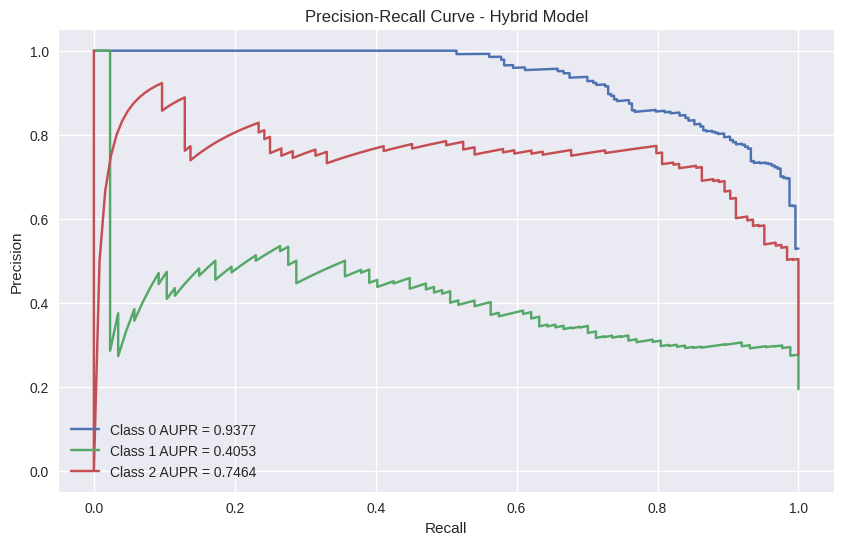

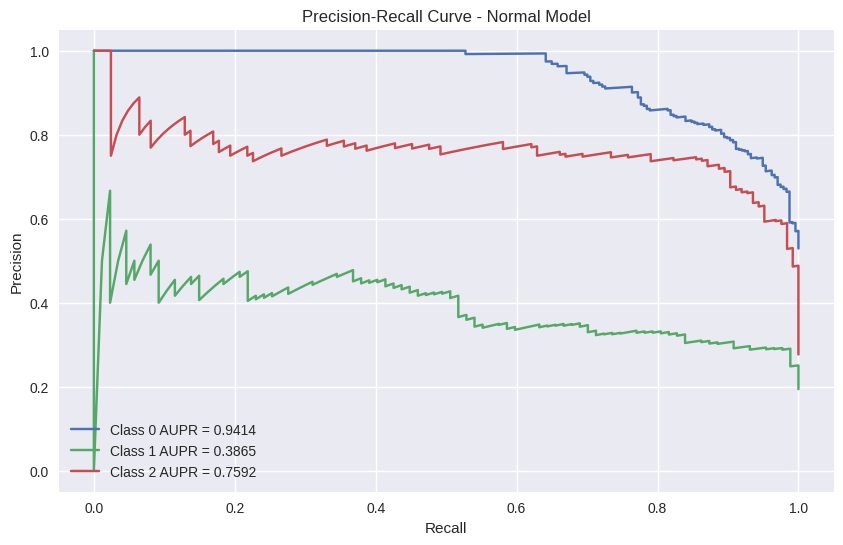

In [ ]:
test(model_hybrid, model_normal, test_loader, num_classes=num_classes)

## Seed Experiments 2

In [ ]:
seed = 42
set_seed(seed)
train_loader, valid_loader, test_loader = load_data(batch_size=batch_size, dataset=dataset)
model = NormalModel(freeze=True, num_classes=num_classes)
hybrid_model = QuantumHybridModel(q_depth=4, freeze=True, num_classes=num_classes)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
model_normal, normal_train_losses, normal_train_accs, normal_val_losses, normal_val_accs, normal_train_aucs, normal_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=model,
    model_name=model_name_normal,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed
)

Epoch [1/100]
Training Loss: 1.0041, Training Accuracy: 36.11%, Training AUROC: 0.5856
Validation Loss: 0.8181, Validation Accuracy: 35.94%, Validation AUROC: 0.4117
Epoch [2/100]
Training Loss: 0.8692, Training Accuracy: 56.25%, Training AUROC: 0.5781
Validation Loss: 0.5820, Validation Accuracy: 81.25%, Validation AUROC: 0.4086
Epoch [3/100]
Training Loss: 0.7754, Training Accuracy: 68.75%, Training AUROC: 0.5746
Validation Loss: 0.4615, Validation Accuracy: 84.38%, Validation AUROC: 0.3389
Epoch [4/100]
Training Loss: 0.7750, Training Accuracy: 68.06%, Training AUROC: 0.5954
Validation Loss: 0.4464, Validation Accuracy: 84.38%, Validation AUROC: 0.3506
Epoch [5/100]
Training Loss: 0.7708, Training Accuracy: 67.36%, Training AUROC: 0.6301
Validation Loss: 0.4697, Validation Accuracy: 84.38%, Validation AUROC: 0.3840
Epoch [6/100]
Training Loss: 0.7499, Training Accuracy: 68.75%, Training AUROC: 0.6257
Validation Loss: 0.5076, Validation Accuracy: 82.81%, Validation AUROC: 0.3963
Epoc

In [ ]:
model_hybrid, hybrid_train_losses, hybrid_train_accs, hybrid_val_losses, hybrid_val_accs, hybrid_train_aucs, hybrid_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=hybrid_model,
    model_name=model_name_hybrid,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed
)

Epoch [1/100]
Training Loss: 1.0914, Training Accuracy: 24.65%, Training AUROC: 0.4969
Validation Loss: 1.1046, Validation Accuracy: 6.25%, Validation AUROC: 0.2389
Epoch [2/100]
Training Loss: 0.9522, Training Accuracy: 50.35%, Training AUROC: 0.4770
Validation Loss: 0.6923, Validation Accuracy: 82.81%, Validation AUROC: 0.2278
Epoch [3/100]
Training Loss: 0.8232, Training Accuracy: 67.71%, Training AUROC: 0.4884
Validation Loss: 0.5355, Validation Accuracy: 84.38%, Validation AUROC: 0.2395
Epoch [4/100]
Training Loss: 0.7710, Training Accuracy: 68.40%, Training AUROC: 0.5519
Validation Loss: 0.4929, Validation Accuracy: 84.38%, Validation AUROC: 0.2698
Epoch [5/100]
Training Loss: 0.7742, Training Accuracy: 67.71%, Training AUROC: 0.5922
Validation Loss: 0.4835, Validation Accuracy: 84.38%, Validation AUROC: 0.3062
Epoch [6/100]
Training Loss: 0.7572, Training Accuracy: 68.75%, Training AUROC: 0.6154
Validation Loss: 0.4845, Validation Accuracy: 84.38%, Validation AUROC: 0.3438
Epoch

<ipython-input-16-c59c089c574e>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


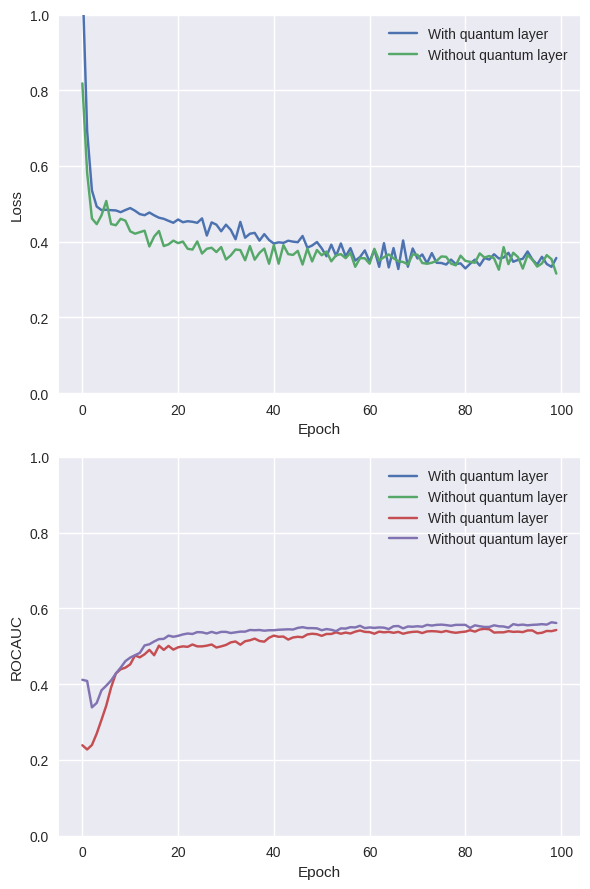

In [ ]:
plot(hybrid_val_losses, normal_val_losses, hybrid_val_accs, normal_val_accs, hybrid_val_aucs, normal_val_aucs)

Hybrid Model Accuracy: 76.04%
Normal Model Accuracy: 78.12%
Hybrid Model F1 Score: 0.7411
Normal Model F1 Score: 0.7329
Hybrid Model AUC: 0.8178
Normal Model AUC: 0.8521


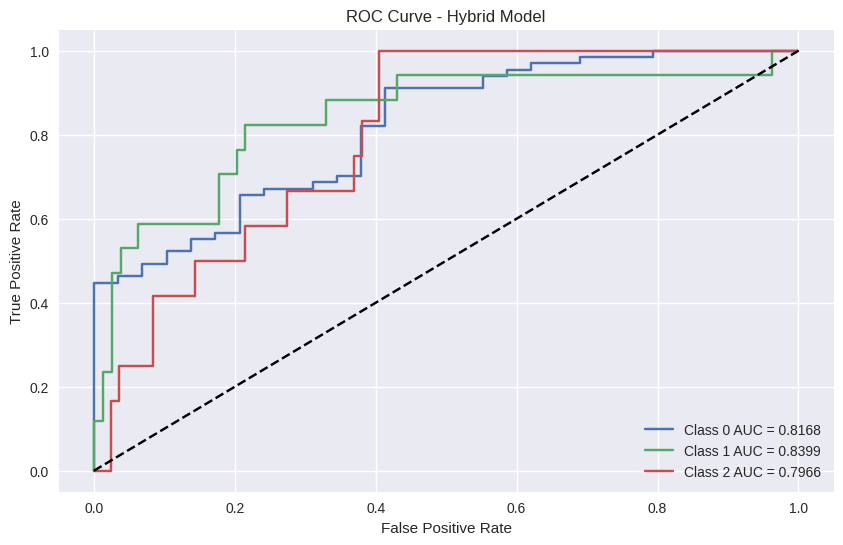

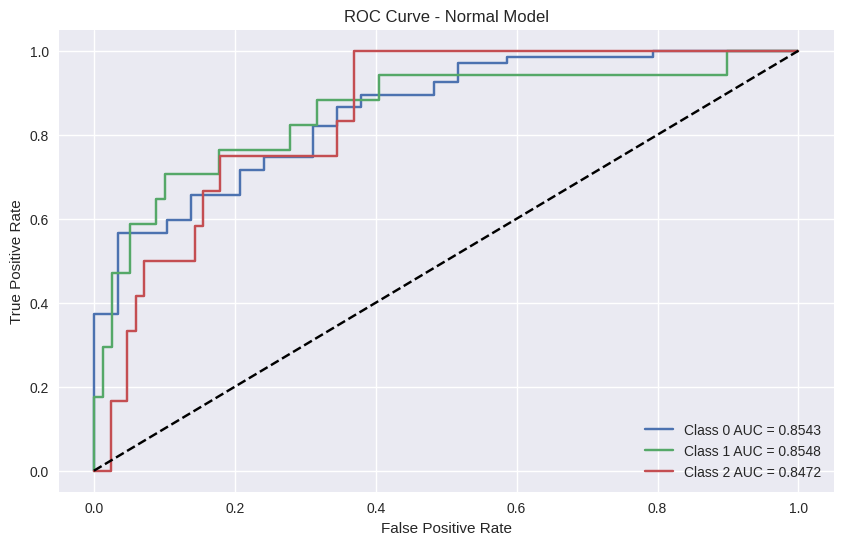

Hybrid Model AUPR: 0.6079
Normal Model AUPR: 0.6475


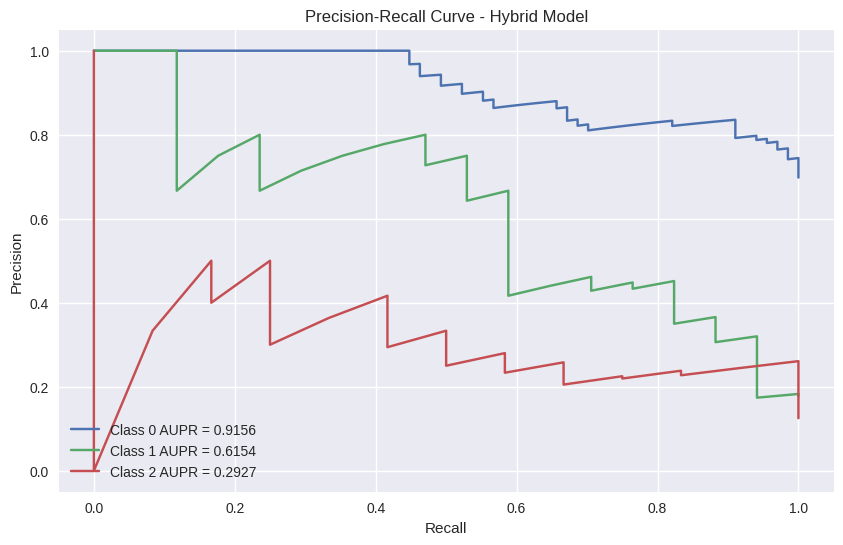

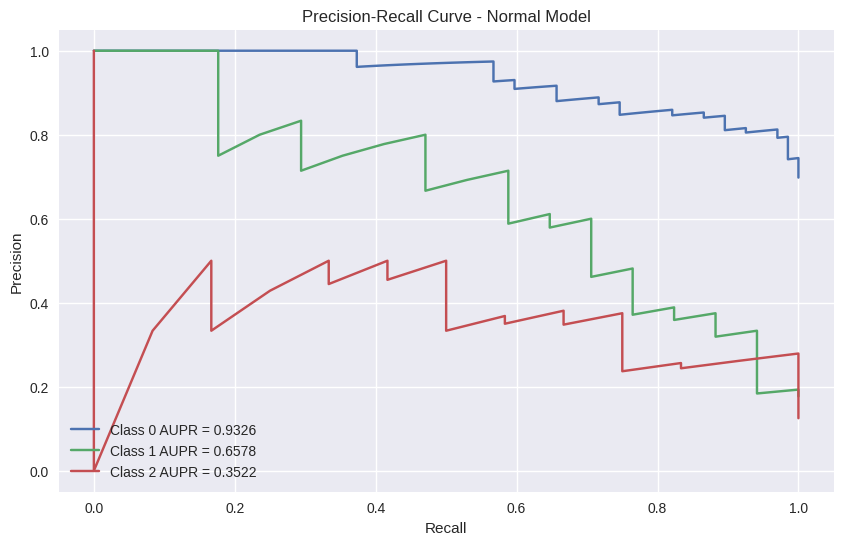

In [ ]:
test(model_hybrid, model_normal, test_loader, num_classes=num_classes)

## Seed Experiments 3

In [ ]:
seed = 5923
set_seed(seed)
train_loader, valid_loader, test_loader = load_data(batch_size=batch_size, dataset=dataset)
model = NormalModel(freeze=True, num_classes=num_classes)
hybrid_model = QuantumHybridModel(q_depth=4, freeze=True, num_classes=num_classes)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
model_normal, normal_train_losses, normal_train_accs, normal_val_losses, normal_val_accs, normal_train_aucs, normal_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=model,
    model_name=model_name_normal,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed
)

Epoch [1/100]
Training Loss: 1.0660, Training Accuracy: 44.23%, Training AUROC: 0.4986
Validation Loss: 0.9078, Validation Accuracy: 54.69%, Validation AUROC: 0.4703
Epoch [2/100]
Training Loss: 0.9852, Training Accuracy: 53.00%, Training AUROC: 0.5669
Validation Loss: 0.8612, Validation Accuracy: 57.81%, Validation AUROC: 0.5899
Epoch [3/100]
Training Loss: 0.9012, Training Accuracy: 56.85%, Training AUROC: 0.6888
Validation Loss: 0.8055, Validation Accuracy: 58.85%, Validation AUROC: 0.6837
Epoch [4/100]
Training Loss: 0.8482, Training Accuracy: 61.42%, Training AUROC: 0.7409
Validation Loss: 0.7786, Validation Accuracy: 59.90%, Validation AUROC: 0.7355
Epoch [5/100]
Training Loss: 0.7786, Training Accuracy: 67.19%, Training AUROC: 0.7935
Validation Loss: 0.7244, Validation Accuracy: 61.98%, Validation AUROC: 0.7728
Epoch [6/100]
Training Loss: 0.7169, Training Accuracy: 69.83%, Training AUROC: 0.8319
Validation Loss: 0.6733, Validation Accuracy: 63.02%, Validation AUROC: 0.7988
Epoc

In [ ]:
model_hybrid, hybrid_train_losses, hybrid_train_accs, hybrid_val_losses, hybrid_val_accs, hybrid_train_aucs, hybrid_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=hybrid_model,
    model_name=model_name_hybrid,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed
)

Epoch [1/100]
Training Loss: 1.0107, Training Accuracy: 51.32%, Training AUROC: 0.5319
Validation Loss: 0.9132, Validation Accuracy: 56.77%, Validation AUROC: 0.5937
Epoch [2/100]
Training Loss: 0.9881, Training Accuracy: 53.37%, Training AUROC: 0.5894
Validation Loss: 0.8917, Validation Accuracy: 58.33%, Validation AUROC: 0.6608
Epoch [3/100]
Training Loss: 0.9698, Training Accuracy: 54.81%, Training AUROC: 0.6814
Validation Loss: 0.8690, Validation Accuracy: 59.38%, Validation AUROC: 0.7364
Epoch [4/100]
Training Loss: 0.9402, Training Accuracy: 58.17%, Training AUROC: 0.7511
Validation Loss: 0.8525, Validation Accuracy: 63.54%, Validation AUROC: 0.7717
Epoch [5/100]
Training Loss: 0.9161, Training Accuracy: 64.66%, Training AUROC: 0.7924
Validation Loss: 0.8364, Validation Accuracy: 61.46%, Validation AUROC: 0.8003
Epoch [6/100]
Training Loss: 0.8897, Training Accuracy: 68.87%, Training AUROC: 0.8211
Validation Loss: 0.8111, Validation Accuracy: 65.62%, Validation AUROC: 0.8276
Epoc

<ipython-input-17-c59c089c574e>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


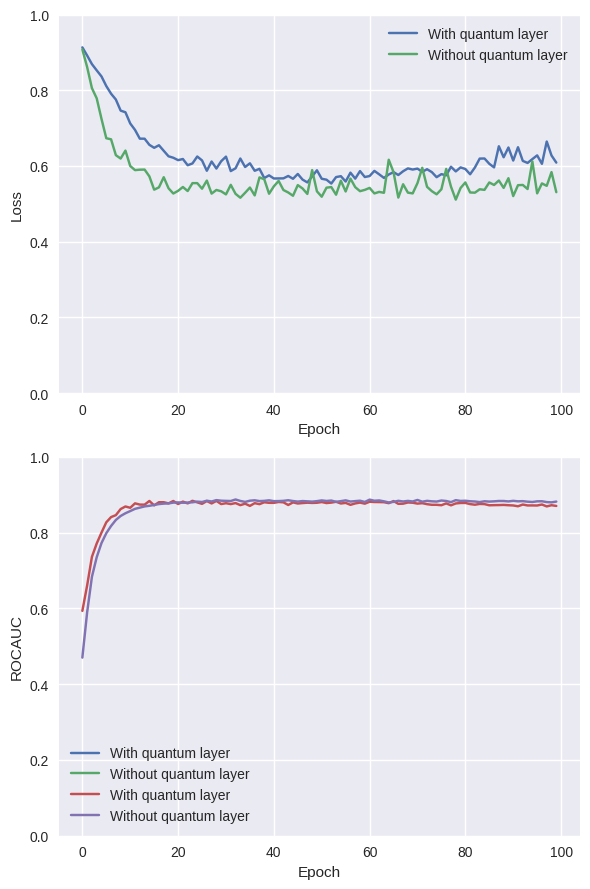

In [ ]:
plot(hybrid_val_losses, normal_val_losses, hybrid_val_accs, normal_val_accs, hybrid_val_aucs, normal_val_aucs)

Hybrid Model Accuracy: 74.78%
Normal Model Accuracy: 73.66%
Hybrid Model F1 Score: 0.7401
Normal Model F1 Score: 0.7237
Hybrid Model AUC: 0.8681
Normal Model AUC: 0.8737


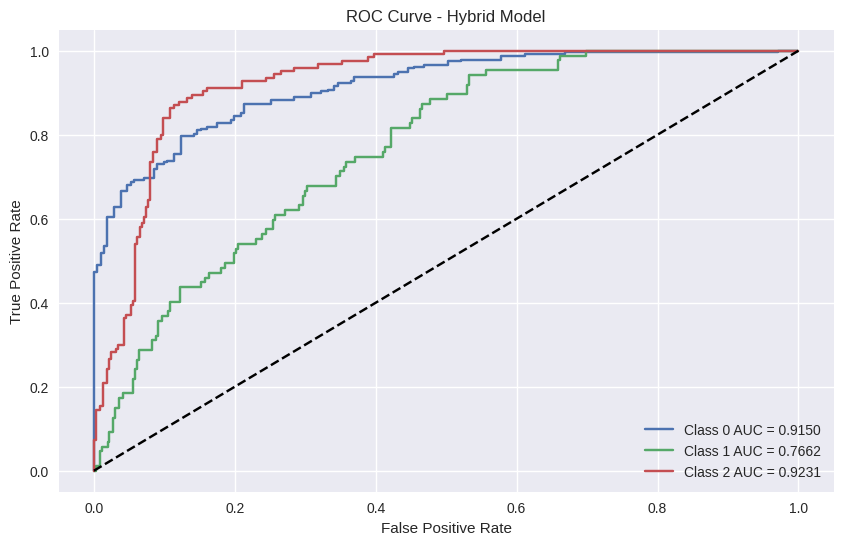

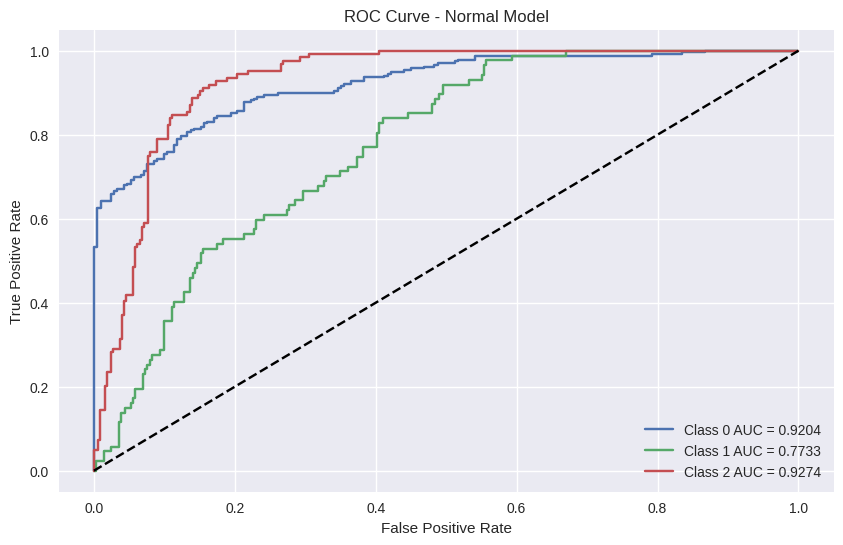

Hybrid Model AUPR: 0.7011
Normal Model AUPR: 0.6954


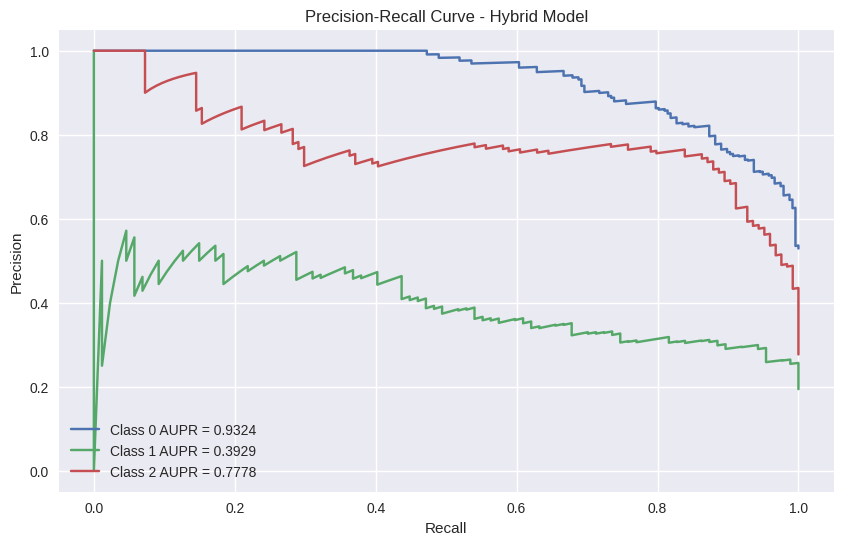

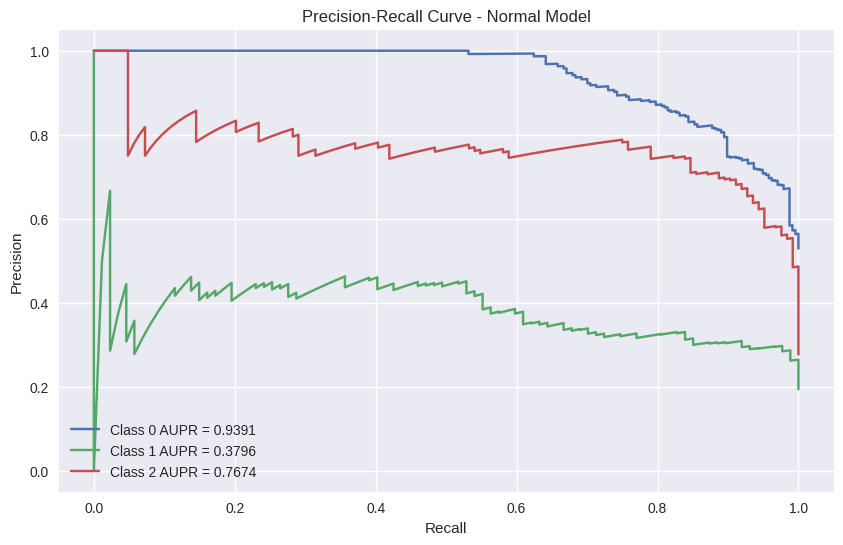

In [ ]:
test(model_hybrid, model_normal, test_loader, num_classes=num_classes)

## Seed Experiments 4

In [ ]:
seed = 8932
set_seed(seed)
train_loader, valid_loader, test_loader = load_data(batch_size=batch_size, dataset=dataset)
model = NormalModel(freeze=True, num_classes=num_classes)
hybrid_model = QuantumHybridModel(q_depth=4, freeze=True, num_classes=num_classes)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
model_normal, normal_train_losses, normal_train_accs, normal_val_losses, normal_val_accs, normal_train_aucs, normal_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=model,
    model_name=model_name_normal,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed
)

Epoch [1/100]
Training Loss: 1.0444, Training Accuracy: 42.31%, Training AUROC: 0.5447
Validation Loss: 0.9037, Validation Accuracy: 53.65%, Validation AUROC: 0.5499
Epoch [2/100]
Training Loss: 0.9706, Training Accuracy: 52.52%, Training AUROC: 0.5830
Validation Loss: 0.8620, Validation Accuracy: 58.33%, Validation AUROC: 0.5767
Epoch [3/100]
Training Loss: 0.9258, Training Accuracy: 55.77%, Training AUROC: 0.6438
Validation Loss: 0.8190, Validation Accuracy: 59.38%, Validation AUROC: 0.6571
Epoch [4/100]
Training Loss: 0.8496, Training Accuracy: 59.13%, Training AUROC: 0.7274
Validation Loss: 0.7796, Validation Accuracy: 58.85%, Validation AUROC: 0.7206
Epoch [5/100]
Training Loss: 0.7917, Training Accuracy: 62.38%, Training AUROC: 0.7827
Validation Loss: 0.7190, Validation Accuracy: 63.54%, Validation AUROC: 0.7696
Epoch [6/100]
Training Loss: 0.7368, Training Accuracy: 66.59%, Training AUROC: 0.8171
Validation Loss: 0.6911, Validation Accuracy: 62.50%, Validation AUROC: 0.7972
Epoc

In [ ]:
model_hybrid, hybrid_train_losses, hybrid_train_accs, hybrid_val_losses, hybrid_val_accs, hybrid_train_aucs, hybrid_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=hybrid_model,
    model_name=model_name_hybrid,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed
)

Epoch [1/100]
Training Loss: 0.9945, Training Accuracy: 50.96%, Training AUROC: 0.5659
Validation Loss: 0.8675, Validation Accuracy: 57.81%, Validation AUROC: 0.5724
Epoch [2/100]
Training Loss: 0.9663, Training Accuracy: 52.04%, Training AUROC: 0.6152
Validation Loss: 0.8656, Validation Accuracy: 62.50%, Validation AUROC: 0.6521
Epoch [3/100]
Training Loss: 0.9302, Training Accuracy: 56.37%, Training AUROC: 0.7163
Validation Loss: 0.8401, Validation Accuracy: 63.54%, Validation AUROC: 0.6968
Epoch [4/100]
Training Loss: 0.8877, Training Accuracy: 63.10%, Training AUROC: 0.7534
Validation Loss: 0.8139, Validation Accuracy: 64.58%, Validation AUROC: 0.7071
Epoch [5/100]
Training Loss: 0.8375, Training Accuracy: 68.87%, Training AUROC: 0.8040
Validation Loss: 0.7839, Validation Accuracy: 66.15%, Validation AUROC: 0.7535
Epoch [6/100]
Training Loss: 0.8041, Training Accuracy: 70.31%, Training AUROC: 0.8318
Validation Loss: 0.7697, Validation Accuracy: 65.10%, Validation AUROC: 0.7569
Epoc

<ipython-input-17-c59c089c574e>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


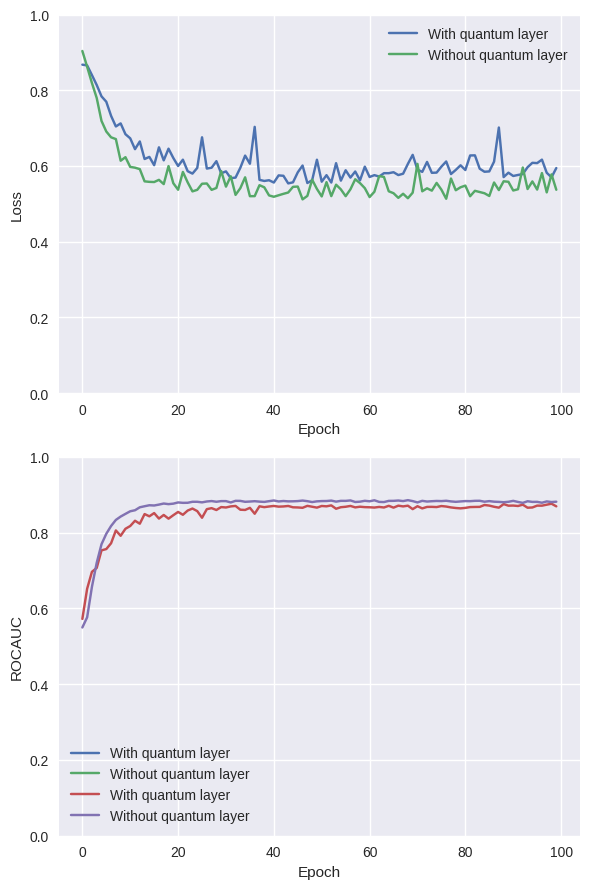

In [ ]:
plot(hybrid_val_losses, normal_val_losses, hybrid_val_accs, normal_val_accs, hybrid_val_aucs, normal_val_aucs)

Hybrid Model Accuracy: 73.66%
Normal Model Accuracy: 75.00%
Hybrid Model F1 Score: 0.7318
Normal Model F1 Score: 0.7460
Hybrid Model AUC: 0.8728
Normal Model AUC: 0.8766


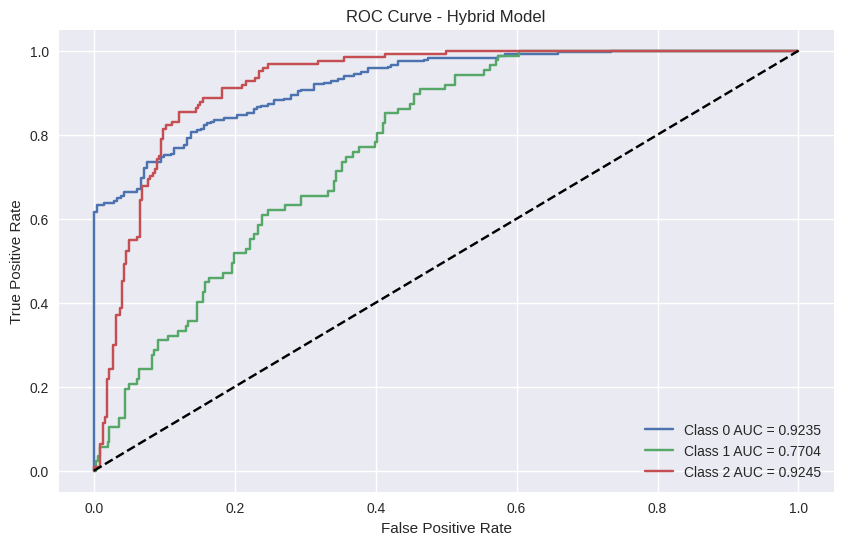

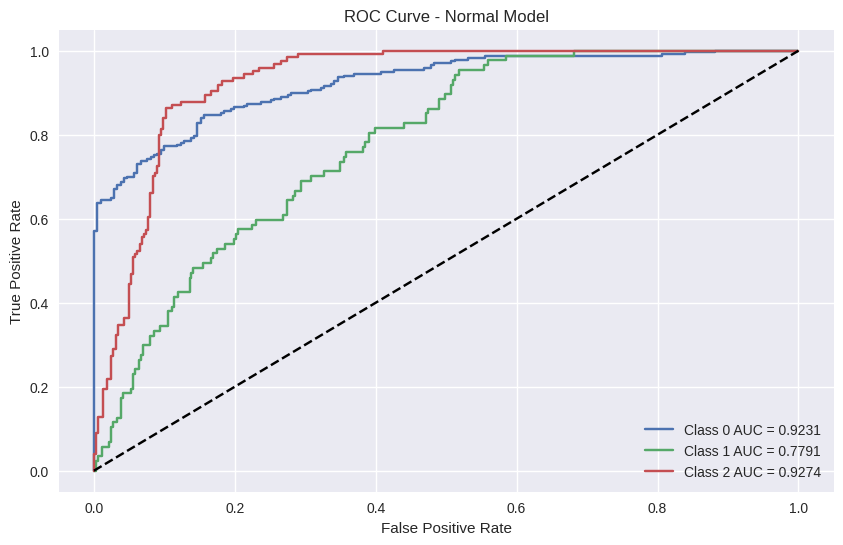

Hybrid Model AUPR: 0.6894
Normal Model AUPR: 0.7055


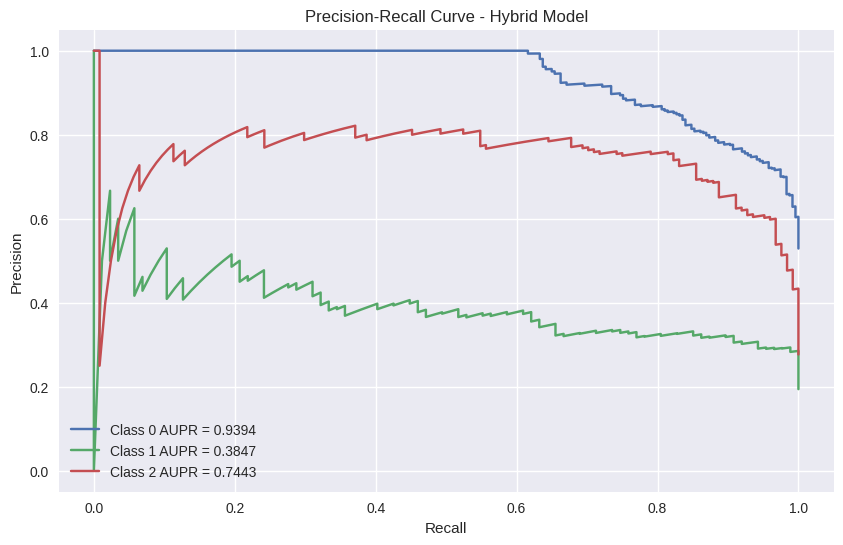

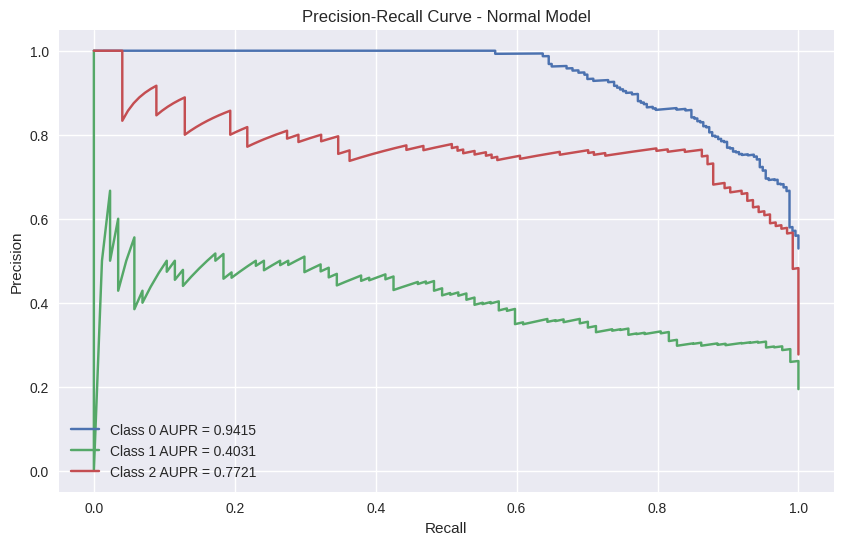

In [ ]:
test(model_hybrid, model_normal, test_loader, num_classes=num_classes)

Seed Experiments 5

In [ ]:
seed = 56
set_seed(seed)
train_loader, valid_loader, test_loader = load_data(batch_size=batch_size, dataset=dataset)
model = NormalModel(freeze=True, num_classes=num_classes)
hybrid_model = QuantumHybridModel(q_depth=4, freeze=True, num_classes=num_classes)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
model_normal, normal_train_losses, normal_train_accs, normal_val_losses, normal_val_accs, normal_train_aucs, normal_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=model,
    model_name=model_name_normal,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed
)

Epoch [1/100]
Training Loss: 1.1783, Training Accuracy: 29.57%, Training AUROC: 0.4989
Validation Loss: 1.0189, Validation Accuracy: 30.21%, Validation AUROC: 0.4868
Epoch [2/100]
Training Loss: 0.9981, Training Accuracy: 48.68%, Training AUROC: 0.5412
Validation Loss: 0.8668, Validation Accuracy: 55.73%, Validation AUROC: 0.5846
Epoch [3/100]
Training Loss: 0.9339, Training Accuracy: 54.09%, Training AUROC: 0.6481
Validation Loss: 0.8322, Validation Accuracy: 59.90%, Validation AUROC: 0.6718
Epoch [4/100]
Training Loss: 0.8633, Training Accuracy: 61.18%, Training AUROC: 0.7423
Validation Loss: 0.7743, Validation Accuracy: 61.46%, Validation AUROC: 0.7425
Epoch [5/100]
Training Loss: 0.8086, Training Accuracy: 63.70%, Training AUROC: 0.7833
Validation Loss: 0.7353, Validation Accuracy: 65.62%, Validation AUROC: 0.7848
Epoch [6/100]
Training Loss: 0.7506, Training Accuracy: 68.51%, Training AUROC: 0.8232
Validation Loss: 0.7043, Validation Accuracy: 68.23%, Validation AUROC: 0.8078
Epoc

In [ ]:
model_hybrid, hybrid_train_losses, hybrid_train_accs, hybrid_val_losses, hybrid_val_accs, hybrid_train_aucs, hybrid_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=hybrid_model,
    model_name=model_name_hybrid,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed
)

Epoch [1/100]
Training Loss: 1.1395, Training Accuracy: 30.17%, Training AUROC: 0.4885
Validation Loss: 0.9624, Validation Accuracy: 38.54%, Validation AUROC: 0.4724
Epoch [2/100]
Training Loss: 1.0099, Training Accuracy: 47.72%, Training AUROC: 0.5164
Validation Loss: 0.8687, Validation Accuracy: 57.29%, Validation AUROC: 0.5299
Epoch [3/100]
Training Loss: 0.9626, Training Accuracy: 52.16%, Training AUROC: 0.5974
Validation Loss: 0.8513, Validation Accuracy: 58.33%, Validation AUROC: 0.6087
Epoch [4/100]
Training Loss: 0.9291, Training Accuracy: 56.25%, Training AUROC: 0.6629
Validation Loss: 0.8229, Validation Accuracy: 63.02%, Validation AUROC: 0.6760
Epoch [5/100]
Training Loss: 0.8733, Training Accuracy: 64.54%, Training AUROC: 0.7256
Validation Loss: 0.7859, Validation Accuracy: 64.06%, Validation AUROC: 0.7182
Epoch [6/100]
Training Loss: 0.8145, Training Accuracy: 69.71%, Training AUROC: 0.7800
Validation Loss: 0.7455, Validation Accuracy: 63.54%, Validation AUROC: 0.7585
Epoc

<ipython-input-17-c59c089c574e>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


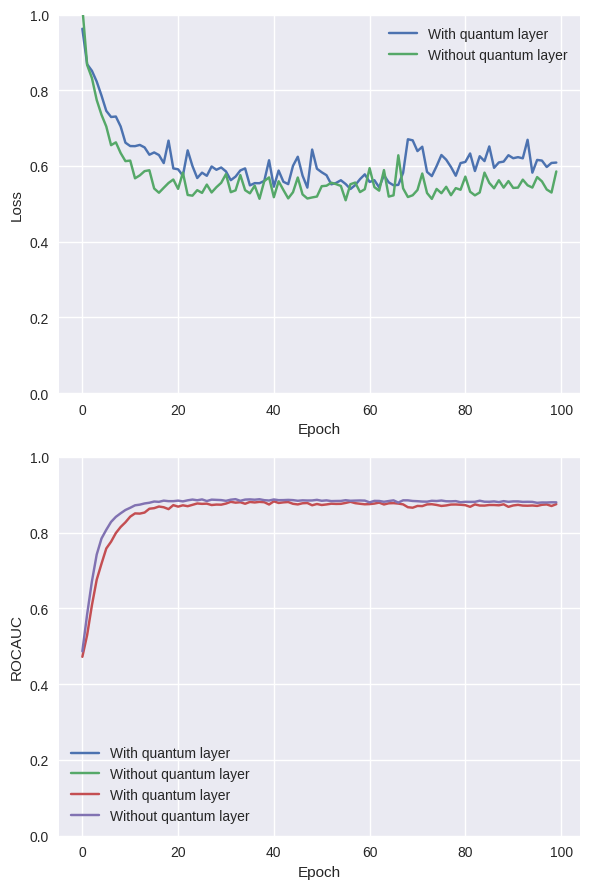

In [ ]:
plot(hybrid_val_losses, normal_val_losses, hybrid_val_accs, normal_val_accs, hybrid_val_aucs, normal_val_aucs)

Hybrid Model Accuracy: 74.78%
Normal Model Accuracy: 73.88%
Hybrid Model F1 Score: 0.7373
Normal Model F1 Score: 0.7411
Hybrid Model AUC: 0.8654
Normal Model AUC: 0.8717


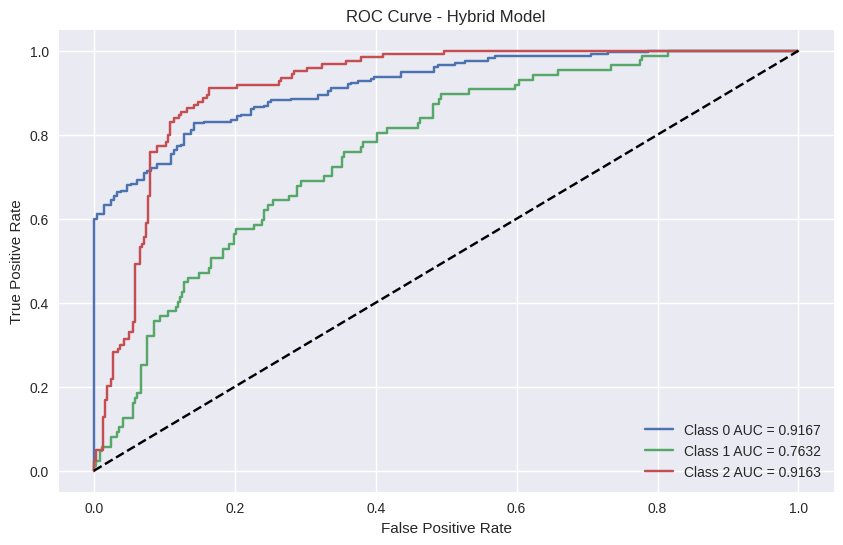

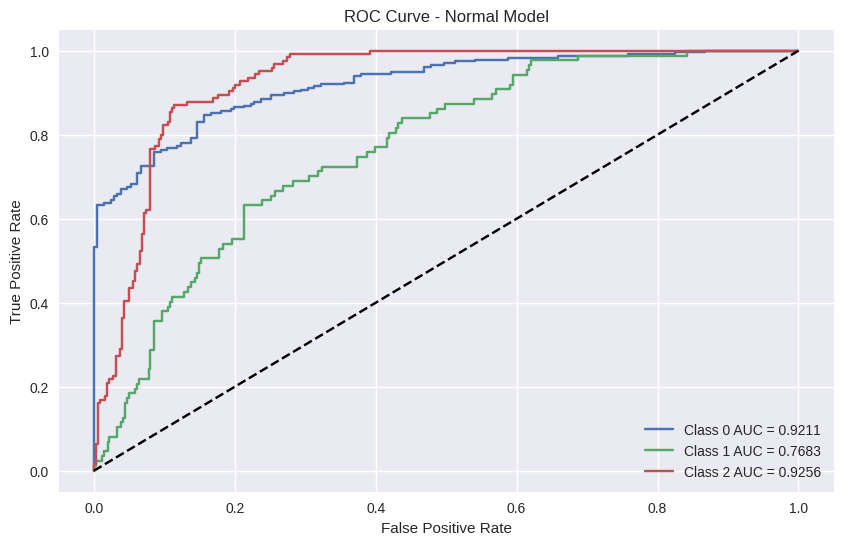

Hybrid Model AUPR: 0.6887
Normal Model AUPR: 0.6990


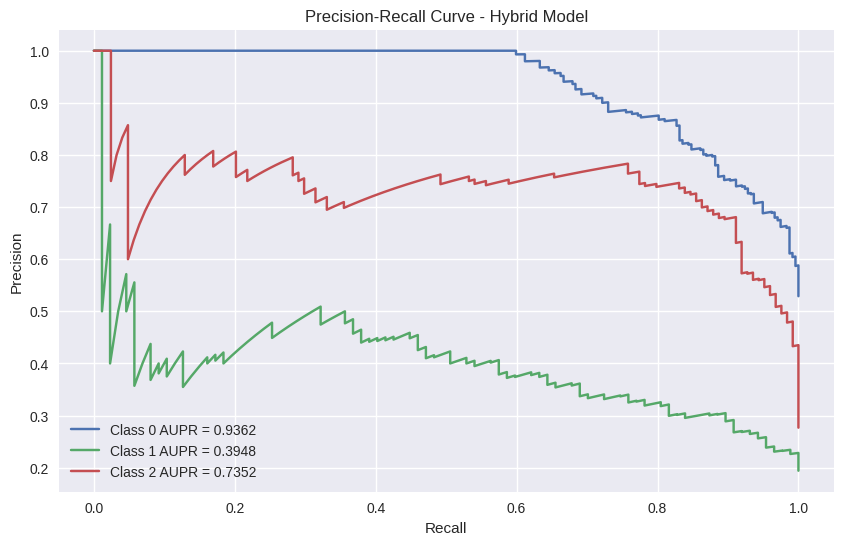

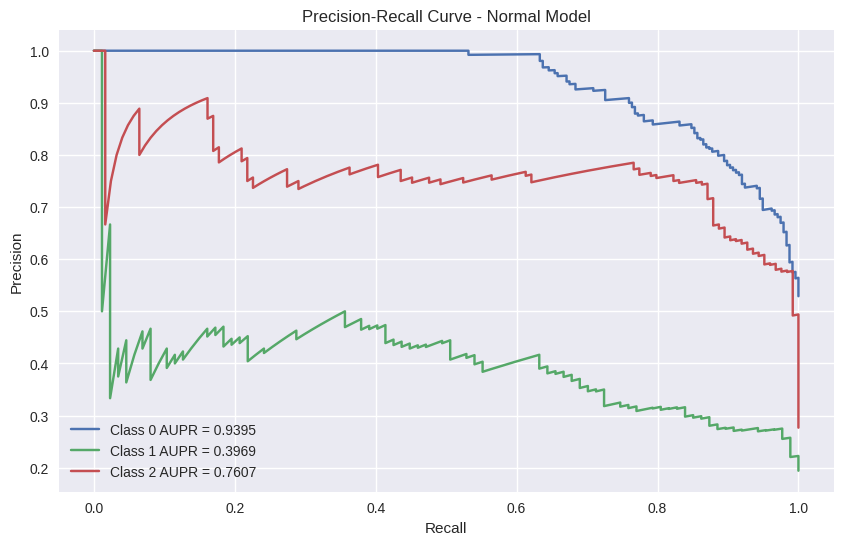

In [ ]:
test(model_hybrid, model_normal, test_loader, num_classes=num_classes)

# Experimenting GlaucomaFundus-Trained Model on PAPILA

In [ ]:
batch_size = 32
dataset = "PAPILA"
num_classes=3
q_depth = 4

In [ ]:
train_loader, valid_loader, test_loader = load_data(batch_size=batch_size, dataset=dataset)

### Testing Model From Seed 1

Hybrid Model Accuracy: 33.33%
Normal Model Accuracy: 30.21%
Hybrid Model F1 Score: 0.3318
Normal Model F1 Score: 0.3045
Hybrid Model AUC: 0.5532
Normal Model AUC: 0.5479


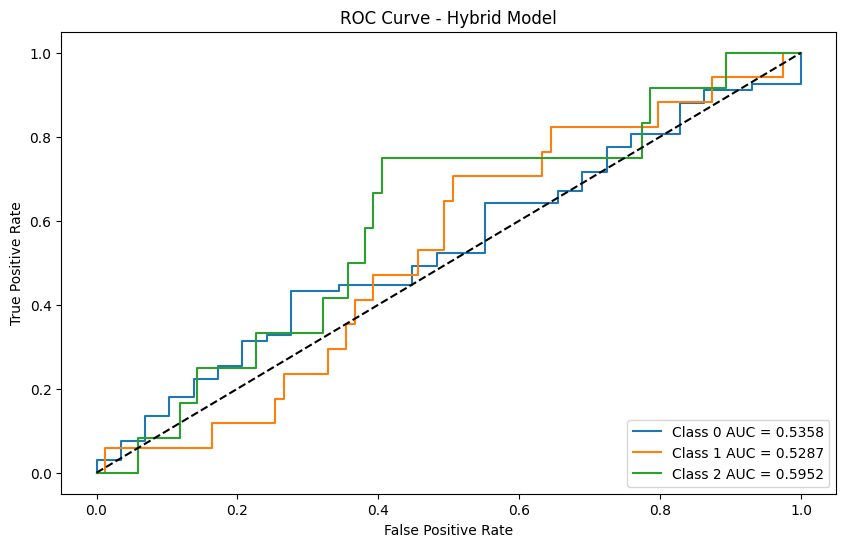

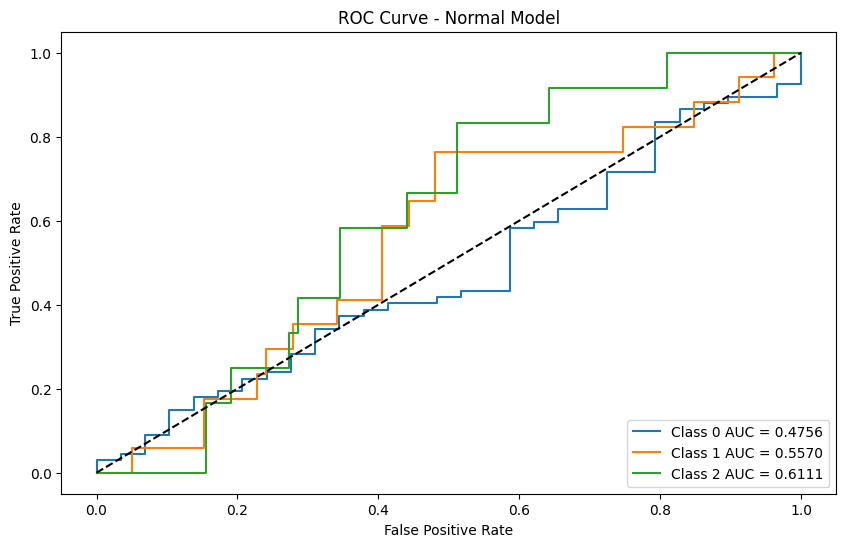

Hybrid Model AUPR: 0.3557
Normal Model AUPR: 0.3436


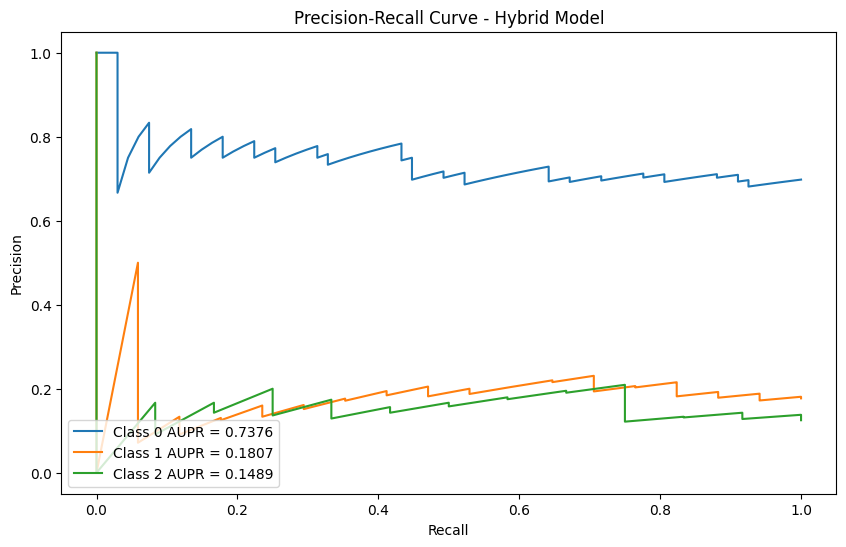

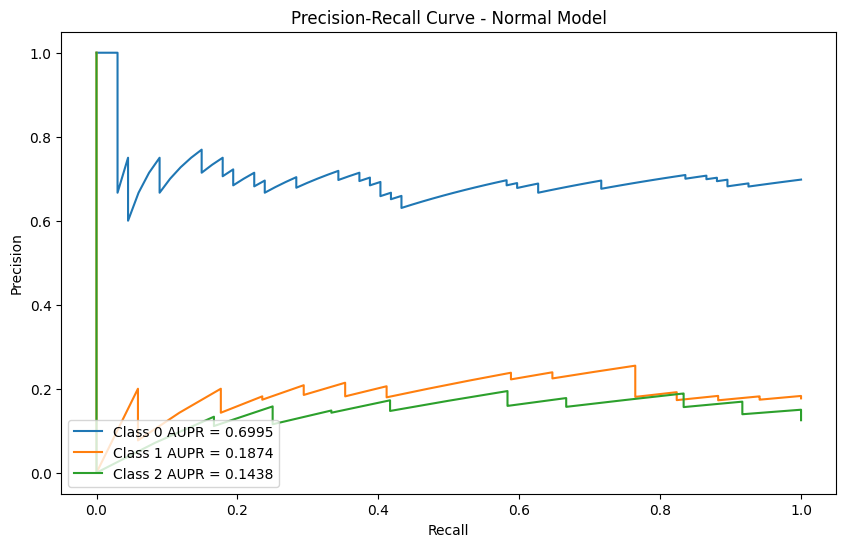

In [ ]:
model_normal = torch.load("/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/GlaucomaFundus_models/normal_model_0.pth", weights_only=False)
model_hybrid = torch.load("/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/GlaucomaFundus_models/quantum_hybrid_model_0.pth", weights_only=False)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
test(model_hybrid, model_normal, test_loader, num_classes)

### Testing Model From Seed 2

Hybrid Model Accuracy: 76.04%
Normal Model Accuracy: 78.12%
Hybrid Model F1 Score: 0.7411
Normal Model F1 Score: 0.7329
Hybrid Model AUC: 0.8178
Normal Model AUC: 0.8521


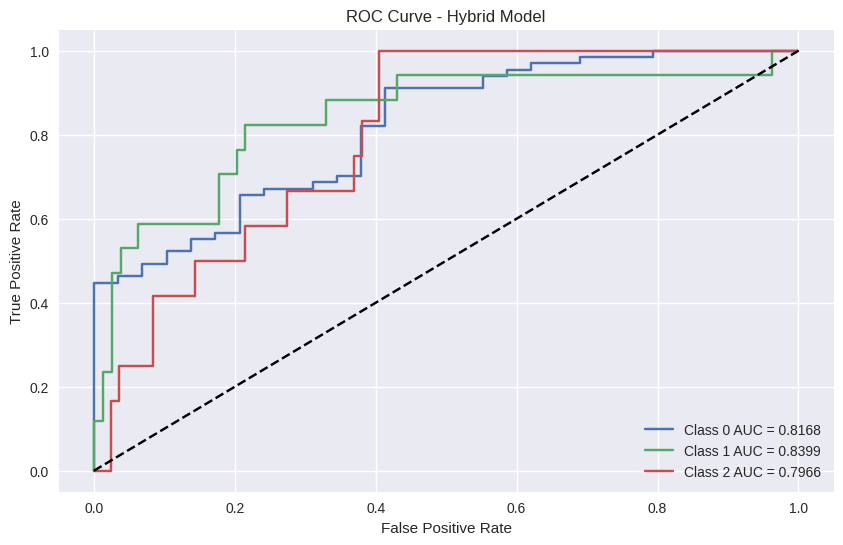

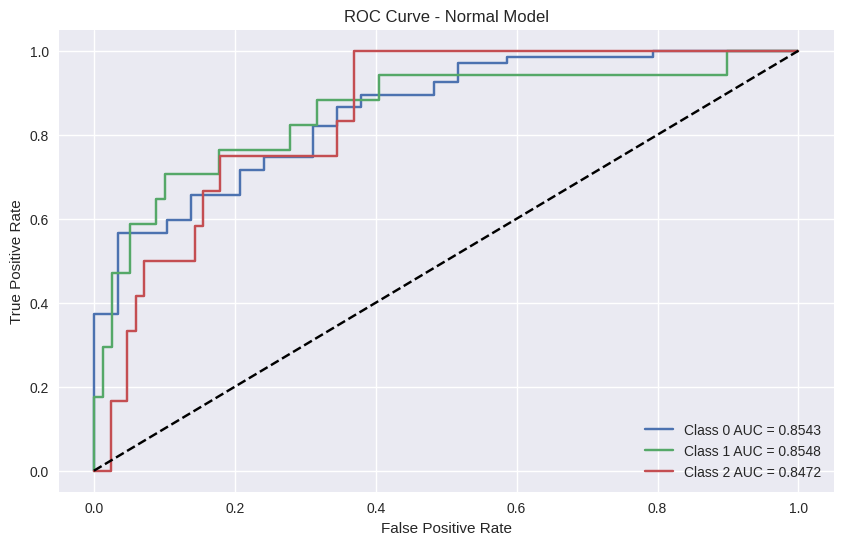

Hybrid Model AUPR: 0.6079
Normal Model AUPR: 0.6475


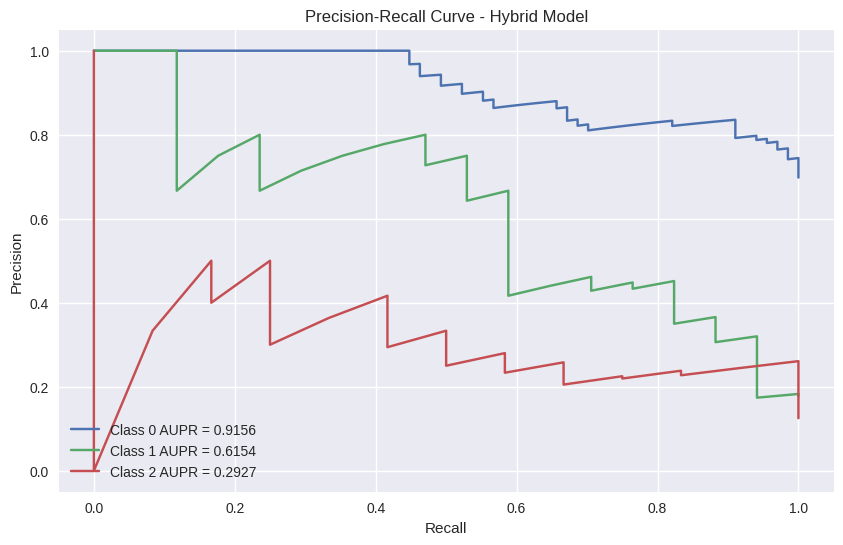

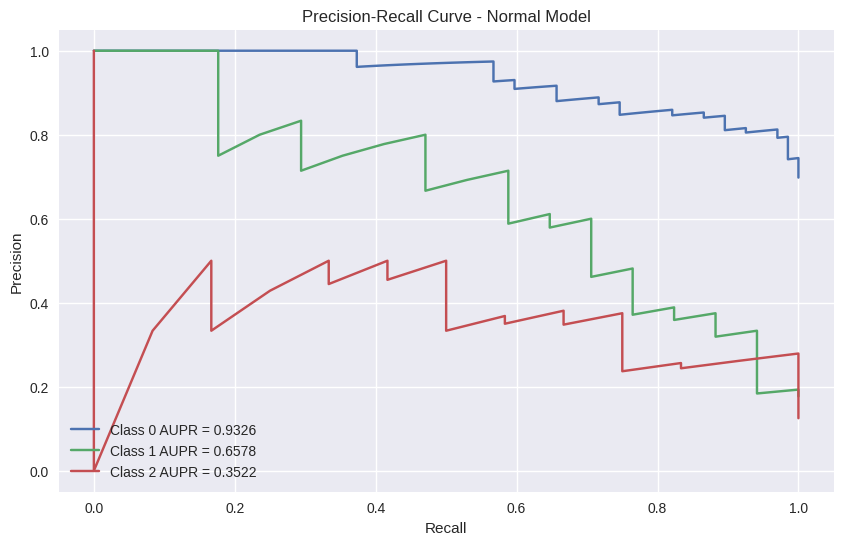

In [ ]:
model_normal = torch.load("/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/GlaucomaFundus_models/normal_model_42.pth", weights_only=False)
model_hybrid = torch.load("/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/GlaucomaFundus_models/quantum_hybrid_model_42.pth", weights_only=False)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
test(model_hybrid, model_normal, test_loader, num_classes)

### Testing Model From Seed 3

Hybrid Model Accuracy: 26.04%
Normal Model Accuracy: 19.79%
Hybrid Model F1 Score: 0.2298
Normal Model F1 Score: 0.1140
Hybrid Model AUC: 0.5316
Normal Model AUC: 0.5355


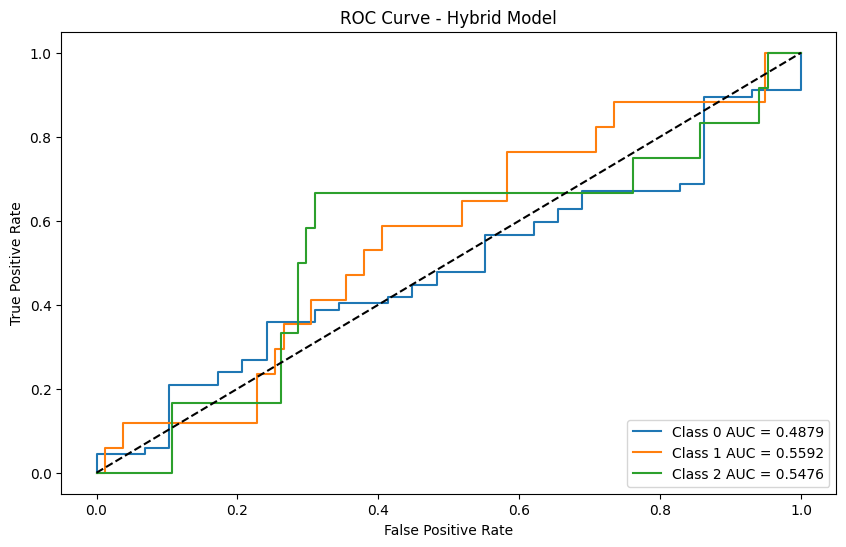

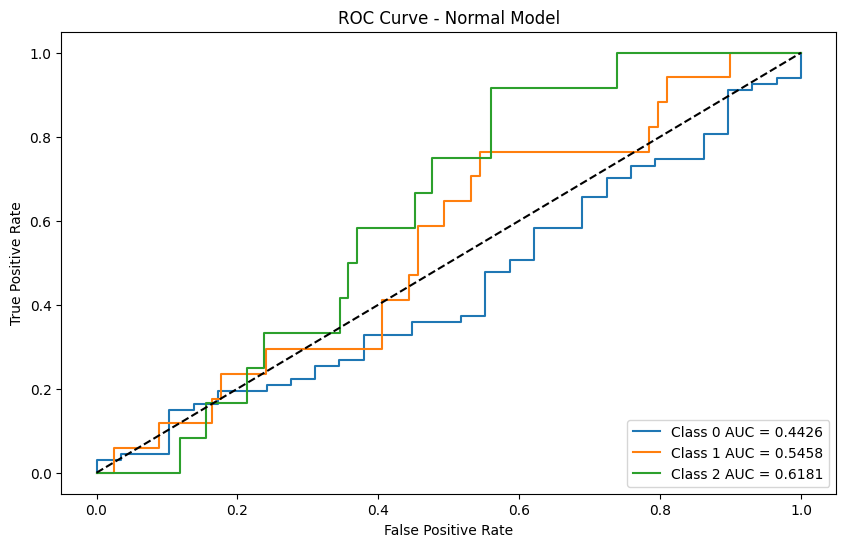

Hybrid Model AUPR: 0.3537
Normal Model AUPR: 0.3368


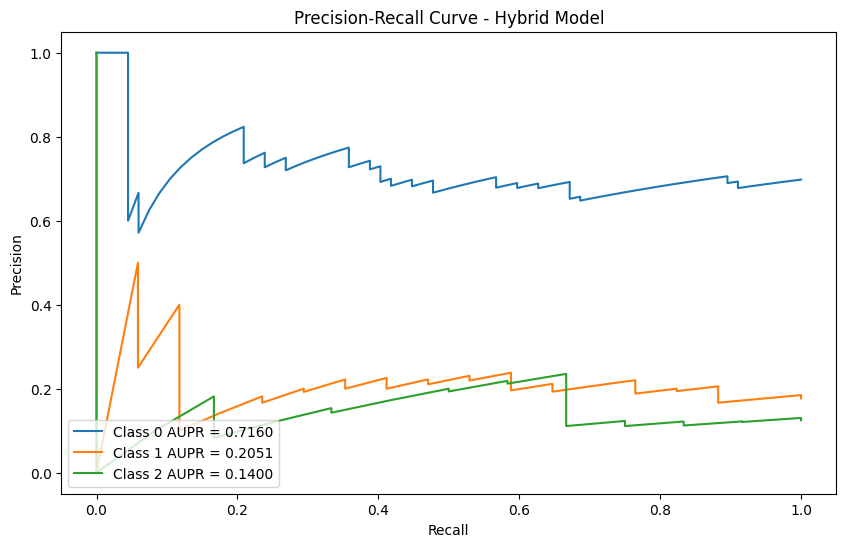

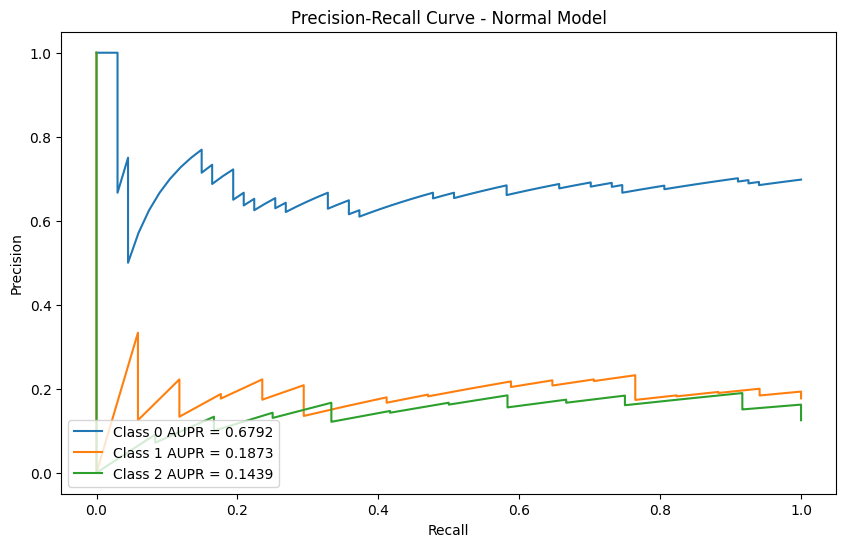

In [ ]:
model_normal = torch.load("/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/GlaucomaFundus_models/normal_model_56.pth", weights_only=False)
model_hybrid = torch.load("/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/GlaucomaFundus_models/quantum_hybrid_model_56.pth", weights_only=False)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
test(model_hybrid, model_normal, test_loader, num_classes)

### Testing Model From Seed 4

Hybrid Model Accuracy: 22.92%
Normal Model Accuracy: 23.96%
Hybrid Model F1 Score: 0.1667
Normal Model F1 Score: 0.2203
Hybrid Model AUC: 0.4920
Normal Model AUC: 0.5384


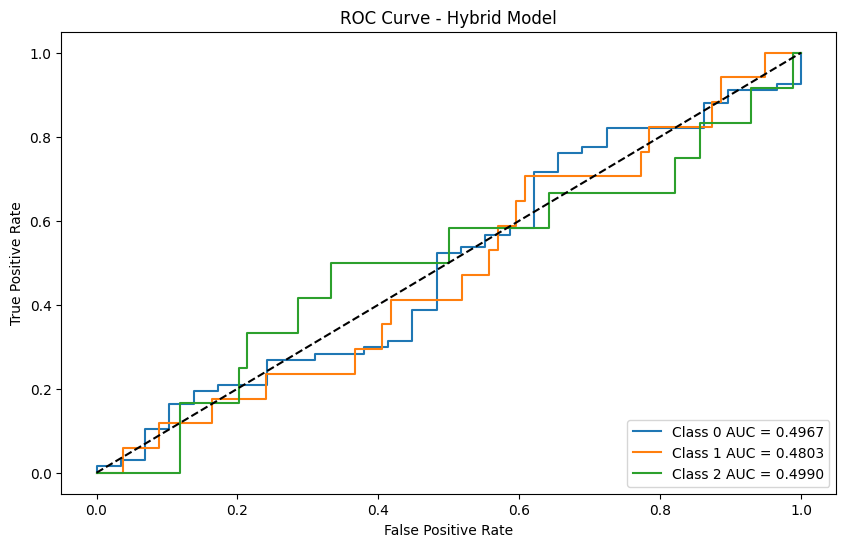

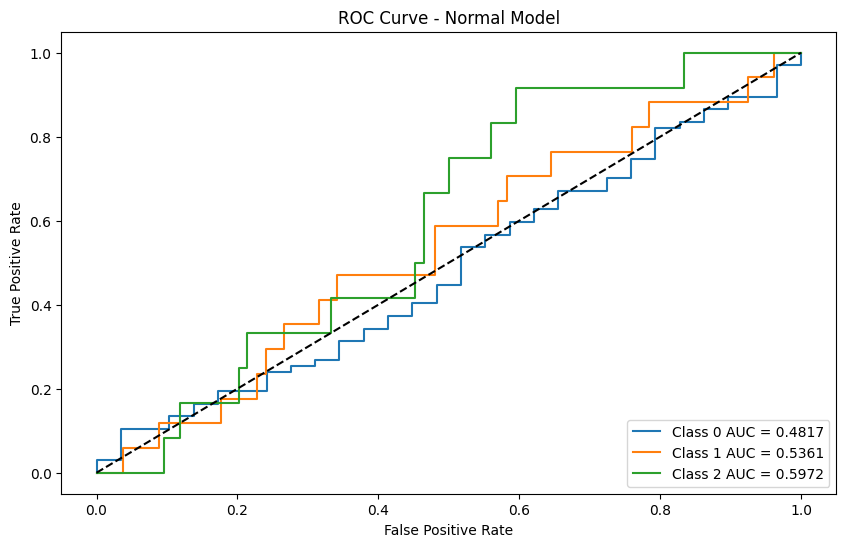

Hybrid Model AUPR: 0.3297
Normal Model AUPR: 0.3436


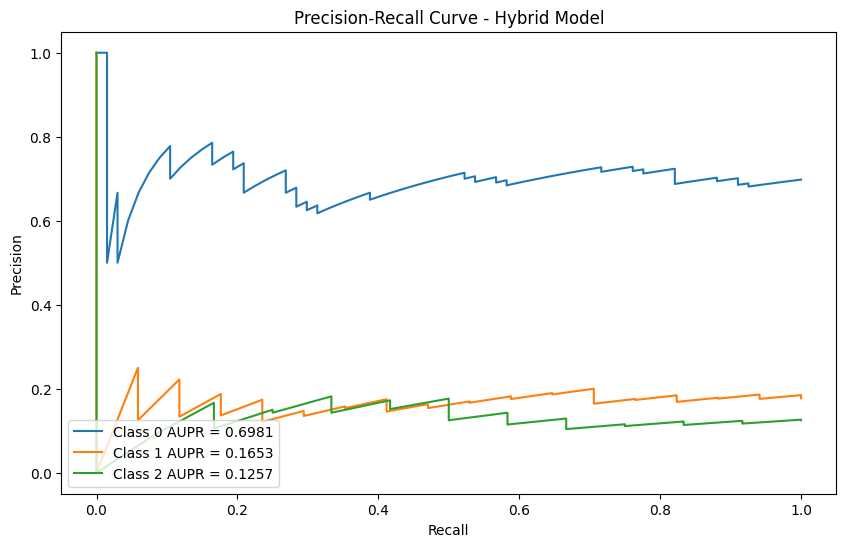

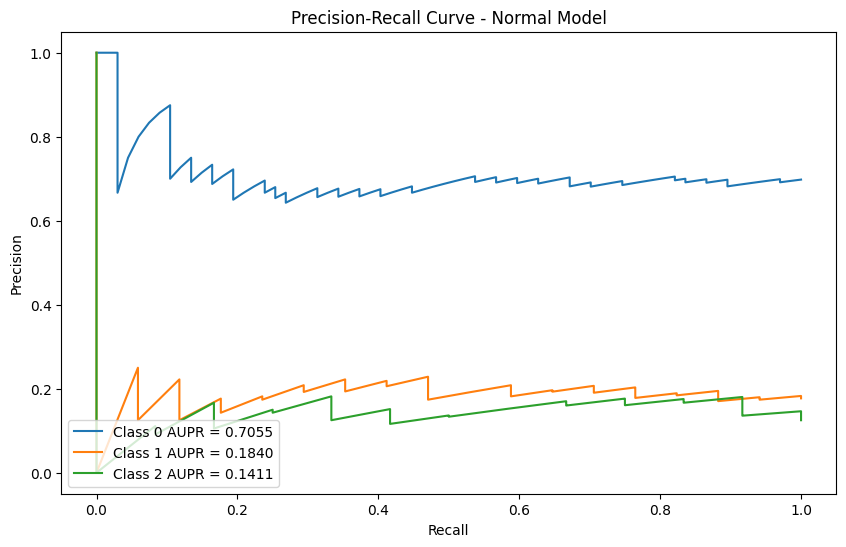

In [ ]:
model_normal = torch.load("/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/GlaucomaFundus_models/normal_model_8932.pth", weights_only=False)
model_hybrid = torch.load("/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/GlaucomaFundus_models/quantum_hybrid_model_8932.pth", weights_only=False)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
test(model_hybrid, model_normal, test_loader, num_classes)

### Testing Model From Seed 5

Hybrid Model Accuracy: 26.04%
Normal Model Accuracy: 23.96%
Hybrid Model F1 Score: 0.2400
Normal Model F1 Score: 0.2092
Hybrid Model AUC: 0.5141
Normal Model AUC: 0.5234


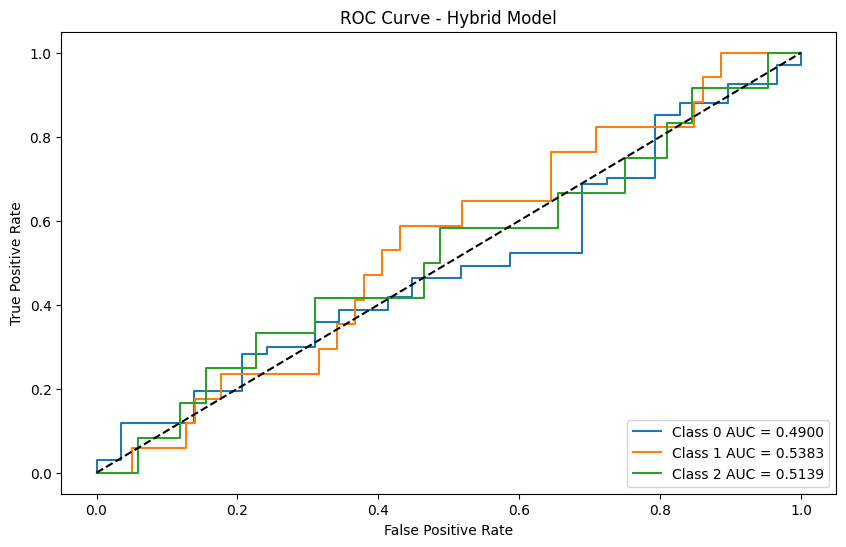

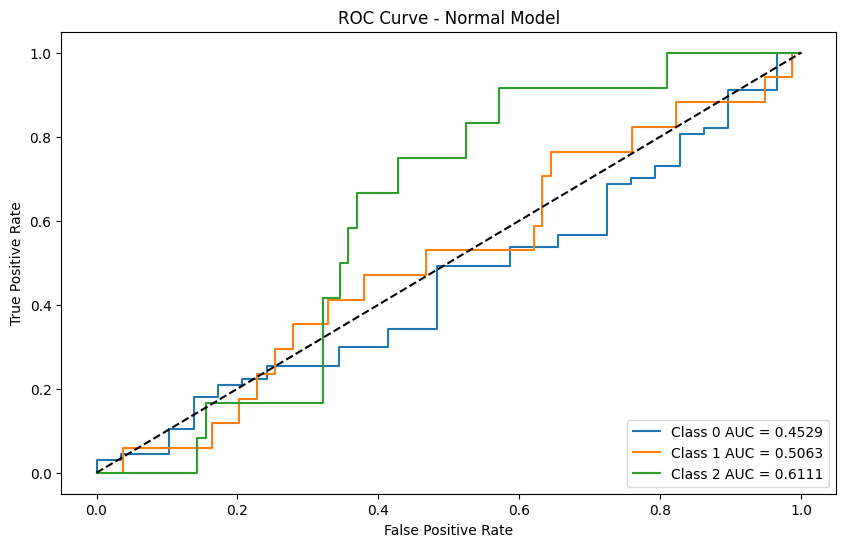

Hybrid Model AUPR: 0.3421
Normal Model AUPR: 0.3328


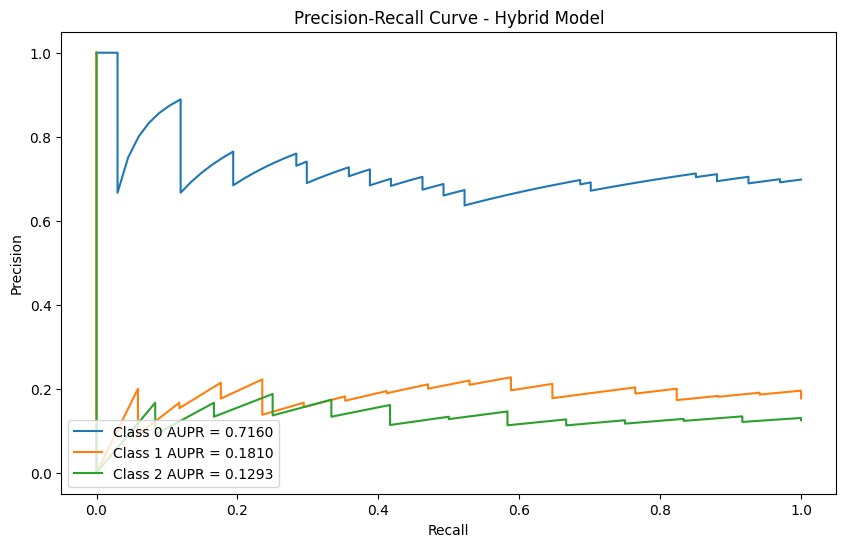

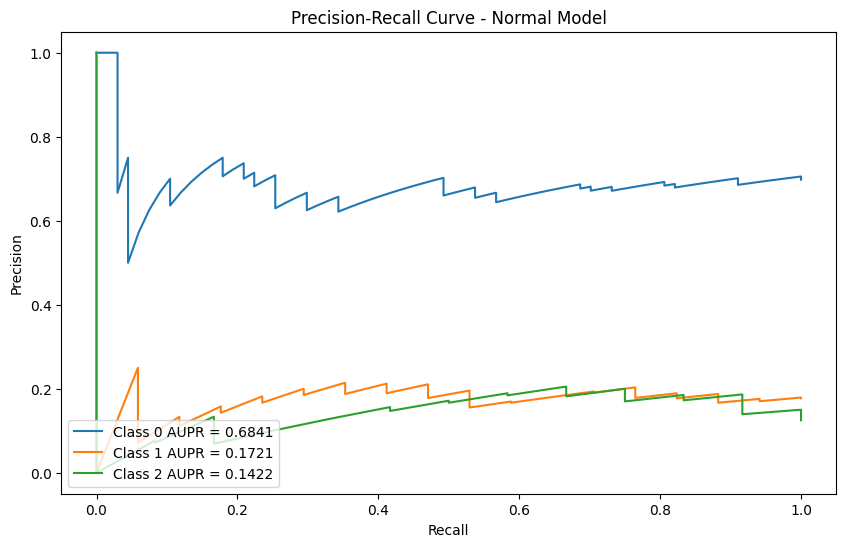

In [ ]:
model_normal = torch.load("/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/GlaucomaFundus_models/normal_model_5923.pth", weights_only=False)
model_hybrid = torch.load("/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/GlaucomaFundus_models/quantum_hybrid_model_5923.pth", weights_only=False)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
test(model_hybrid, model_normal, test_loader, num_classes)